This project aim to compute the LCA of several designs of small wind turbines (SWT) in order to highlight some compromises between height and diameter. It is focused on the design of Piggott wind turbines given in the handbook "Construire une éolienne Piggott" ("Build a Piggott wind turbine") adapt from the book "A Wind Turbine Recipe Book" of Hugh Piggott by the association Tripalium published in 2023. All the data come from this handbook. 

# Initialization of the project

In [2]:
import os 
import xlwings as xw

import brightway2 as bw
import bw2data as bd
from bw2data.parameters import ActivityParameter, DatabaseParameter, ProjectParameter, Group,ParameterSet
import bw2io as bi
import bw2analyzer as bwa
import bw2calc as bc
import lca_algebraic as agb

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib import colormaps

import time
import sympy as sp
from sklearn.metrics import r2_score



#bi.bw2setup()# setup a project, only when you begin it => import the Biosphere database

# To do : update the name of the bightway project
NAME_PROJECT='ACV Paramétrique mat'

# To do : update the name of the user database that will be stored in the brightway project
DB_SYST = 'bdd_syst'

#Open a brightway project associated with the project name chosen
bd.projects.set_current(NAME_PROJECT)
bd.projects.current

# Reset the database, create it if it doesn't exist
agb.resetDb(DB_SYST)

# Reset the definition of all parameters 
agb.resetParams()

# Print the databases that have been set up with lca_algebraic function
agb.list_databases() 

[WARNING] Db bdd_syst was here. Reseting it


,backend,nb_activities,type
name,,,
biosphere3,sqlite,4421,biosphere
ecoinvent-3.8-cutoff,sqlite,19565,background
bdd_elec,sqlite,0,foreground
bdd_gene,sqlite,0,foreground
bdd_mat,sqlite,0,foreground
bdd_syst,sqlite,0,foreground


## Functional unit

The functional unit (FU) of our LCA is the quantity of energy produced during the lifetime of the wind turbine, which is 20 years. The purpose of this part is to create a function which calculate this FU from the diameter and the height of the wind turbine.
To begin with, we take an estimation in kWh of the annual energy production, for different wind turbines and different average wind speed, given in the Table 1 p9. 

We put the data of AEP in a dataframe


In [3]:
AEP_df = pd.DataFrame({'Windspeed [m/s]\Diameter [mm]' : [3,4,5,6],1800 : [144,360,636,888],2400 : [264,648,1116,1572],3000 :[408,1020,1752,2460],3600 : [588,1464,2520,3552],4200 : [804,1992,3432,4824]})
AEP_df.set_index = [3,4,5,6]
AEP_df

,Windspeed [m/s]\Diameter [mm],1800,2400,3000,3600,4200
0,3,144,264,408,588,804
1,4,360,648,1020,1464,1992
2,5,636,1116,1752,2520,3432
3,6,888,1572,2460,3552,4824


Now we calculate the AEP per swept area and we take the mean values

In [4]:
AEPperSA_df = AEP_df.copy()
AEPperSA_df = AEPperSA_df.astype(float)

diam = [1800,2400,3000,3600,4200]
for i in diam : 
    AEPperSA_df[i] = AEPperSA_df[i]/((i*1e-3)**2*np.pi/4)

AEPperSA_df['AEP/SweptArea_avg'] = AEPperSA_df.iloc[:, 1:].mean(axis=1)
AEPperSA_df

,Windspeed [m/s]\Diameter [mm],1800,2400,3000,3600,4200,AEP/SweptArea_avg
0,3,56.5884,58.3568,57.7202,57.7673,58.032,57.693
1,4,141.471,143.239,144.3,143.829,143.781,143.324
2,5,249.932,246.69,247.857,247.574,247.719,247.955
3,6,348.962,347.488,348.019,348.962,348.192,348.325


We create a regression and we calculate the R²


In [5]:
r = AEPperSA_df['AEP/SweptArea_avg']
r.index = AEPperSA_df['Windspeed [m/s]\Diameter [mm]'].values
AEP_coeff= np.polyfit(r.index,r.values, deg = 2)
AEP_reg = np.polyval(AEP_coeff,r.index)
r2 = r2_score(r.values,AEP_reg)


We plot the data and the regression. We see that the AEP/SweptArea is almost independant from the diameter of the windturbine


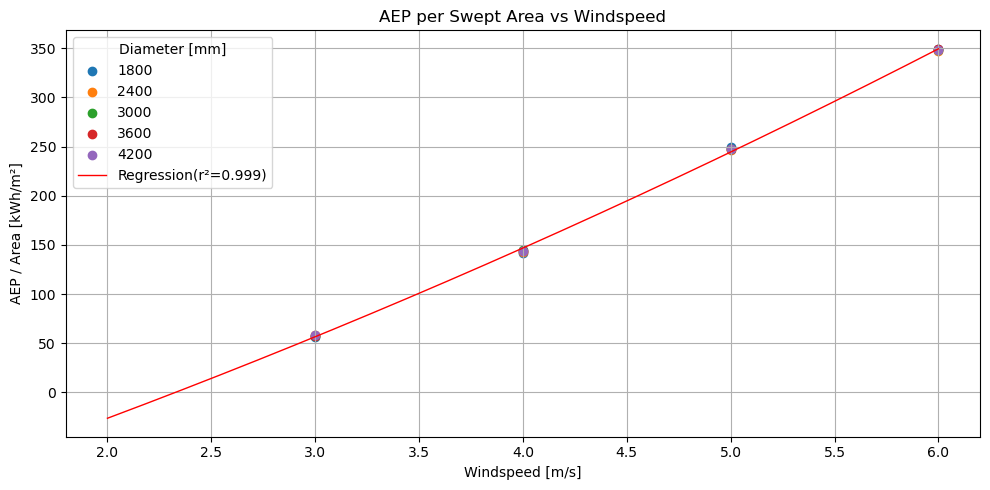

In [6]:
plt.figure(figsize=(10, 5))

for d in diam:
    plt.scatter(AEPperSA_df['Windspeed [m/s]\Diameter [mm]'], AEPperSA_df[d], label=str(d))

x_vals = np.linspace(2, max(AEPperSA_df['Windspeed [m/s]\Diameter [mm]']), 1000)
y_vals = np.polyval(AEP_coeff, x_vals)

plt.plot(x_vals, y_vals, label=f"Regression(r²={round(r2,3)})", color='red', linewidth=1)

plt.xlabel('Windspeed [m/s]')
plt.ylabel('AEP / Area [kWh/m²]')
plt.title('AEP per Swept Area vs Windspeed')
plt.legend(title='Diameter [mm]')
plt.grid(True)
plt.tight_layout()

plt.show()

We can now create the function FU which calculate the energy produced during the lifetime of the wind turbine. 

In [7]:
v_ref = 5 # Annual average windspeed value of site given at h_ref
h_ref = 12.0
z0 = 0.5 # roughness
lifetime = 20 # Lifetime of the windturbine

# This function is in symbolic to be compatible with Brightway 2 and lca_algebraic 
def FU(d,h) : 
    v_moy = v_ref*sp.log((h)/z0)/sp.log((h_ref)/z0)
    swept_area = (d * 1e-3)**2 * np.pi / 4
    return np.polyval(AEP_coeff,v_moy)*swept_area*lifetime

#This is the equivalent function in numeric to be compatible with No Load
def FU_numeric(d,h) :
    v_moy = v_ref*np.log(h/z0)/np.log(h_ref/z0)
    swept_area = (d*1e-3)**2*np.pi/4
    return np.polyval(AEP_coeff, v_moy)*swept_area*lifetime



## Studied impacts

In [8]:
# The impacts are triplets of identifiers of ecoinvent database.
#We built a 16-impacts list
methods_EF=[('EF v3.0','acidification', 'accumulated exceedance (ae)'),
            ('EF v3.0','climate change', 'global warming potential (GWP100)'),
            ('EF v3.0','ecotoxicity: freshwater', 'comparative toxic unit for ecosystems (CTUe)'),
            ('EF v3.0','energy resources: non-renewable', 'abiotic depletion potential (ADP): fossil fuels'),
            ('EF v3.0','eutrophication: freshwater', 'fraction of nutrients reaching freshwater end compartment (P)'),
            ('EF v3.0','eutrophication: marine', 'fraction of nutrients reaching marine end compartment (N)'),
            ('EF v3.0','eutrophication: terrestrial', 'accumulated exceedance (AE)'),
            ('EF v3.0','human toxicity: carcinogenic', 'comparative toxic unit for human (CTUh)'),
            ('EF v3.0','human toxicity: non-carcinogenic', 'comparative toxic unit for human (CTUh)'),
            ('EF v3.0','ionising radiation: human health', 'human exposure efficiency relative to u235'),
            ('EF v3.0','land use', 'soil quality index'),
            ('EF v3.0','material resources: metals/minerals', 'abiotic depletion potential (ADP): elements (ultimate reserves)'),
            ('EF v3.0','ozone depletion', 'ozone depletion potential (ODP)'),
            ('EF v3.0','particulate matter formation', 'impact on human health'),
            ('EF v3.0','photochemical ozone formation: human health', 'tropospheric ozone concentration increase'),
            ('EF v3.0','water use', 'user deprivation potential (deprivation-weighted water consumption)')]
# To show the impact list defined as indicated above
methods_EF

[('EF v3.0', 'acidification', 'accumulated exceedance (ae)'),
 ('EF v3.0', 'climate change', 'global warming potential (GWP100)'),
 ('EF v3.0',
  'ecotoxicity: freshwater',
  'comparative toxic unit for ecosystems (CTUe)'),
 ('EF v3.0',
  'energy resources: non-renewable',
  'abiotic depletion potential (ADP): fossil fuels'),
 ('EF v3.0',
  'eutrophication: freshwater',
  'fraction of nutrients reaching freshwater end compartment (P)'),
 ('EF v3.0',
  'eutrophication: marine',
  'fraction of nutrients reaching marine end compartment (N)'),
 ('EF v3.0', 'eutrophication: terrestrial', 'accumulated exceedance (AE)'),
 ('EF v3.0',
  'human toxicity: carcinogenic',
  'comparative toxic unit for human (CTUh)'),
 ('EF v3.0',
  'human toxicity: non-carcinogenic',
  'comparative toxic unit for human (CTUh)'),
 ('EF v3.0',
  'ionising radiation: human health',
  'human exposure efficiency relative to u235'),
 ('EF v3.0', 'land use', 'soil quality index'),
 ('EF v3.0',
  'material resources: meta

## lca_algebraic parameters

In [9]:
#The diameter of the windturbine
d = agb.newFloatParam(
    "d",
    default = 2400, min = 1800, max=4200,
    label_fr = "Diameter of the windturbine",
    unit = "mm")

#The height of the mast
h = agb.newFloatParam(
    "h",
    default = 18, min = 12, max=30,
    label_fr = "hauteur du mât de l'éolienne",
    unit = "m")


steel_mix = agb.newEnumParam (
    "steel_mix",                     # Short name
    label="Steel production",    # label
    description="Type of technologies use to produce steel", # Long description
    values =[                     # Statistic weight of each option that fits with the market
        "Converter",
        "Converter_elec"],
    default = 'Converter'
    )  


# Parametrization of the inventory

## Sizing of the mast 

In [10]:
rho_steel = 7850

height = np.array([12, 18, 24])

# Generate height values
h_values = np.linspace(12, 30, 20)

### Fundation

#### Concrete

The volume of concrete depends on the height of the mast and the diameter of the wind turbine. Data from Table X pX

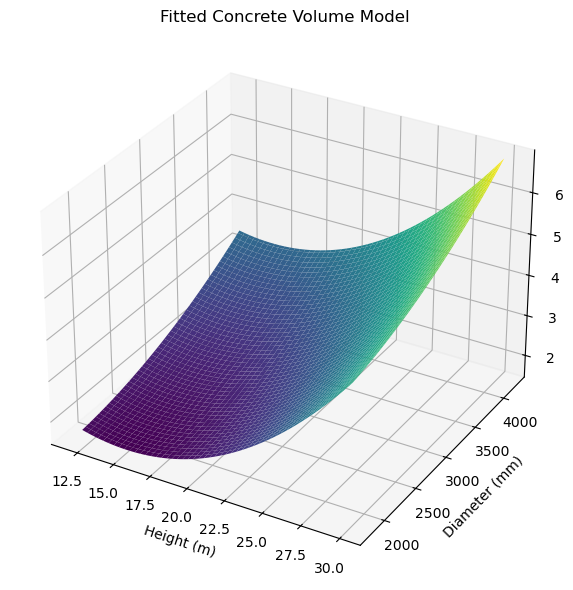

In [14]:
conc_df = pd.DataFrame({'Diameter':[1800,2400,2400,3000,3000,3000,3600,3600,3600,4200,4200,4200],
                        'Height':[12,12,18,12,18,24,12,18,24,12,18,24],
                        'Volume':[0.3*5,0.4*5,0.4*5,0.5*5,0.5*5,0.7*5,0.5*5,0.5*5,0.7*5,0.7*5,0.7*5,1*5]})

a0, a1, a2, a3, a4, a5 = sp.symbols('a0 a1 a2 a3 a4 a5')

f = a0 + a1*h + a2*d + a3*h**2 + a4*h*d + a5*d**2

X = []
y = []

for _, row in conc_df.iterrows():
    hh = row['Height']
    dd = row['Diameter']
    vol = row['Volume']
    X.append([1, hh, dd, hh**2, hh*dd, dd**2])
    y.append(vol)

X = np.array(X)
y = np.array(y)

coeffs, *_ = np.linalg.lstsq(X, y, rcond=None)

conc_fitted_model = f.subs({
    a0: coeffs[0],
    a1: coeffs[1],
    a2: coeffs[2],
    a3: coeffs[3],
    a4: coeffs[4],
    a5: coeffs[5],
})

# Convert symbolic function to numerical function
f_lambdified = sp.lambdify((h, d), conc_fitted_model, modules='numpy')

# Create meshgrid for plotting
h_vals = np.linspace(12, 30, 100)
d_vals = np.linspace(1800, 4200, 100)
H, D = np.meshgrid(h_vals, d_vals)
Z = f_lambdified(H, D)

# Plotting
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(H, D, Z, cmap='viridis', edgecolor='none')

ax.set_xlabel('Height (m)')
ax.set_ylabel('Diameter (mm)')
ax.set_zlabel('Concrete Volume (m³)')
ax.set_title('Fitted Concrete Volume Model')

plt.tight_layout()
plt.savefig("fitted_concrete_volume_model.png", dpi=300)
plt.show()

#### Rebar

In [107]:
rebar_df = pd.DataFrame({'Height':[12,18,24],
                        'Lenght':[25,35,50]})

rebar_coeff = np.polyfit(rebar_df['Height'],rebar_df['Lenght'], deg = 2)

###  Steel tower

In [108]:
#Mast
e_mast = 3.2e-3
D = np.array([88.9,114.3,114.3])*1e-3
D_fit=np.polyfit(height,D,1)

#Yaw
e_yaw1 = 0.0029
D_yaw1 = 0.0603

e_yaw2 = 0.0032
D_yaw2 = 0.0889

e_yaw=np.array([e_yaw1, e_yaw2, e_yaw2])
D_yaw=np.array([D_yaw1, D_yaw2, D_yaw2])

D_yaw_fit=np.polyfit(height,D_yaw,1)
e_yaw_fit=np.polyfit(height,e_yaw,1)

#Pivot
e_pivot = 0.005
D_pivot = np.array([60.3,76,76])*1e-3
L_pivot = np.array([395,480,480])*1e-3

D_pivot_fit = np.polyfit(height,D_pivot,1)
L_pivot_fit = np.polyfit(height,L_pivot,1)

#Regression
def tower_steel_tube_mass(h):
    
    m_yaw=np.pi*np.polyval(e_yaw_fit,h)*rho_steel*h/2*(np.polyval(D_yaw_fit,h)-np.polyval(e_yaw_fit,h))
    m_mast=np.pi*e_mast*rho_steel*h*(np.polyval(D_fit,h)-e_mast)
    m_pivot = np.pi*e_pivot*rho_steel*np.polyval(L_pivot_fit,h)*(np.polyval(D_pivot_fit,h)-e_pivot)
    
    return m_yaw+m_mast+m_pivot
#Real values
def tower_steel_tube_mass_real() : 
    h = np.array([12,18,24])
    m_yaw=np.pi*e_yaw*rho_steel*h/2*(D_yaw-e_yaw)
    m_mast=np.pi*e_mast*rho_steel*h*(D-e_mast)
    m_pivot = np.pi*e_pivot*rho_steel*L_pivot*(D_pivot-e_pivot)

    return m_mast+m_yaw+m_pivot

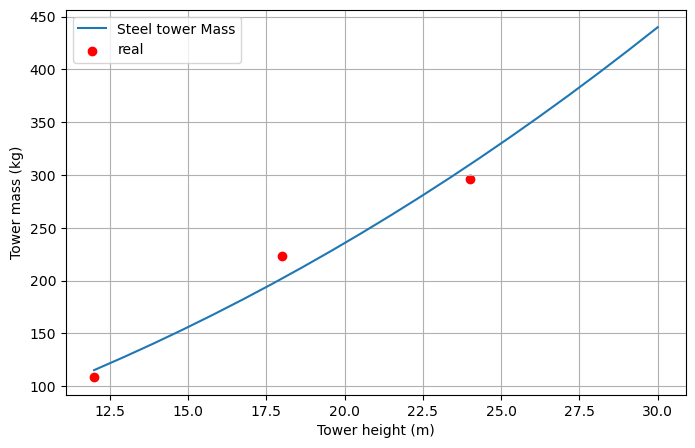

In [109]:
# Plot the function
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(h_values, tower_steel_tube_mass(h_values), label="Steel tower Mass")
ax.scatter(height,tower_steel_tube_mass_real(),label='real',color = 'red')
ax.set_xlabel('Tower height (m)')
ax.set_ylabel('Tower mass (kg)')
ax.grid(True)
ax.legend()
plt.show()

### Guy wire

#### Mass

For the length of the top guy wires $L_c$, we have : 

$L_c = \frac{4h}{\sin(\alpha)} = \frac{8h}{\sqrt3}$

with : 

$\alpha = 60°$ the angle formed between the cable and the ground

$h$ the mast height

Smaller cable are used to strengthen the mast tube with a diameter considered constant of 6 mm. They are connected to the same anchorage as the top cable but they are connected to the mast at 6 m, 12 m and 18 m with a length of $\lambda_1$, $\lambda_2$ and $\lambda_3$.

$\lambda_1 = 4\sqrt{\left(\frac{L}{2}\right)^2+6^2}$

$\lambda_2 = 4\sqrt{\left(\frac{L}{2}\right)^2+12^2}$


$\lambda_3 = 4\sqrt{\left(\frac{L}{2}\right)^2+18^2}$


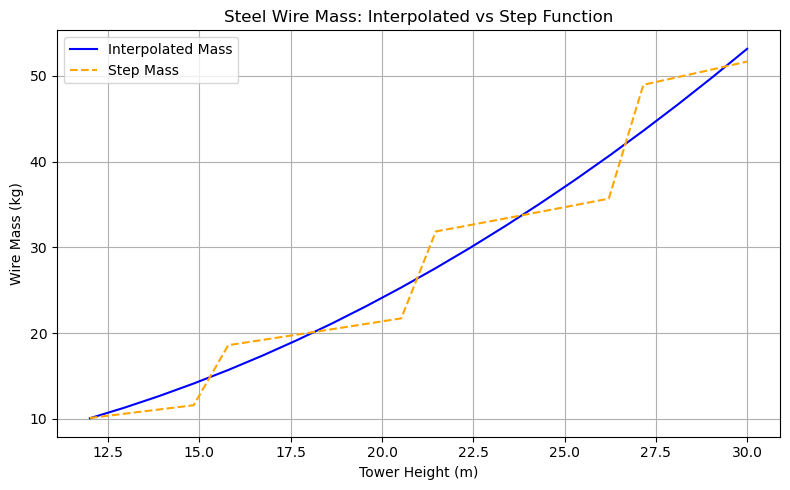

In [110]:
#fill factor of the wires, which translates that there is gaps in the section
k_wire = 0.51

#This coefficient between 0 an 1 defines at which point between 2 height from the handbook, for example 12m and 18m,
#do we add a third layer of cable
coef_add_cable = 0.5

#Function which gives the lenght of wires in relation to the height of the mast, with a step at each new layer of guy wires.
def lenght_wire_steel_step(h):
    L6 = 4 * sp.sqrt((12 / 2) ** 2 + (6) ** 2)
    LT = 8 * h / sp.sqrt(3) #Lenght of wires fixed at the top
    L12 = sp.Piecewise((4 * sp.sqrt((h / 2) ** 2 + 12 ** 2), h > 12+6*coef_add_cable), (0, True))#Lenght of guy wires fixed at 12m
    L18 = sp.Piecewise((4 * sp.sqrt((h / 2) ** 2 + 18 ** 2), h > 18+6*coef_add_cable), (0, True))#Lenght of guy wires fixed at 18m
    L24 = sp.Piecewise((4 * sp.sqrt((h / 2) ** 2 + 24 ** 2), h > 24+6*coef_add_cable), (0, True))#Lenght of guy wires fixed at 24m
    return L6 + LT + L12 + L18 + L24

def mass_wire_steel_step(h):
    S_6 = k_wire * sp.pi * (0.006 / 2) ** 2
    return rho_steel * S_6 * lenght_wire_steel_step(h)

# The regression has been make on a separate sheet
def lenght_wire_steel_regression(h):
    return 38.6 + -2.56*h + 0.564*h**2

def mass_wire_steel(h):
    S_6 = k_wire * sp.pi * (0.006 / 2) ** 2
    return rho_steel * S_6 * lenght_wire_steel_regression(h)


# Lambdify the function
m_wire_step_expr = mass_wire_steel_step(h)
m_wire_step_numeric = sp.lambdify(h, m_wire_step_expr, 'numpy')

# Compute values
m_wire_regression_values = mass_wire_steel(h_values)
m_wire_step_values = m_wire_step_numeric(h_values)

# Plot both
plt.figure(figsize=(8,5))
plt.plot(h_values, m_wire_regression_values, label="Interpolated Mass", color='blue')
plt.plot(h_values, m_wire_step_values, label="Step Mass ", color='orange', linestyle='--')
plt.xlabel('Tower Height (m)')
plt.ylabel('Wire Mass (kg)')
plt.title('Steel Wire Mass: Interpolated vs Step Function')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#### Zinc coating

In [111]:
D_wire = 0.006
A = D_wire**2/4*np.pi #Coated area per meter of cable

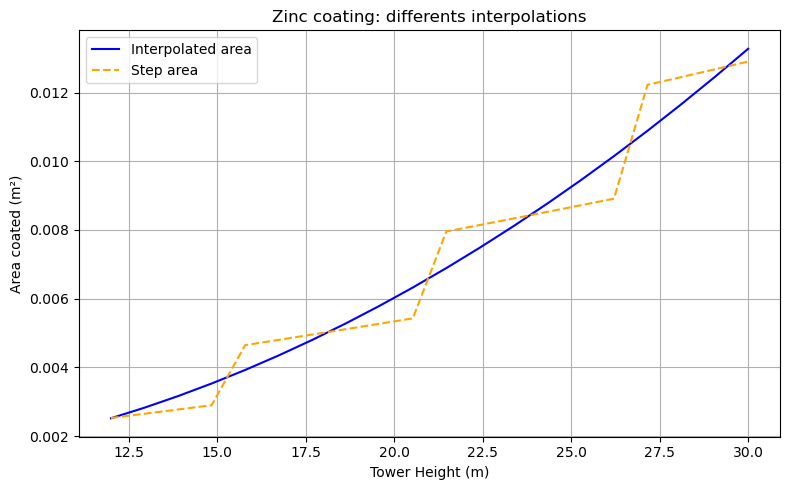

In [112]:
# Lambdify function for the plot

l_wire_step_expr = lenght_wire_steel_step(h)
l_wire_step_numeric = sp.lambdify(h, l_wire_step_expr, 'numpy')

# Compute values
l_values = lenght_wire_steel_regression(h_values)
l_step_values = l_wire_step_numeric(h_values)

# Plot both
plt.figure(figsize=(8,5))
plt.plot(h_values, A*l_values, label="Interpolated area", color='blue')
plt.plot(h_values, A*l_step_values, label="Step area ", color='orange', linestyle='--')
plt.xlabel('Tower Height (m)')
plt.ylabel('Area coated (m²)')
plt.title('Zinc coating: differents interpolations')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Sizing of the wind generator

The regressions are based on an output from the software OpenAFPM, specifically a .FCStd file create with OpenAFPM CAD. All the volumes are then extracted in a .csv file with the code export-volumes.py.

For some elements, such as the wood for blades, the regression is directly made with the data of the handbook.

In [113]:
#Volumic mass in kg/cm³

sm_glassfibre = 0.07 #surfacic mass of the glass fibre in kg/m²
vm_copper = 8960 * 1e-6
vm_mgn = 7500 * 1e-6
vm_plywood = 500 * 1e-6
vm_resin = 1360 * 1e-6
vm_softwood = 500*1e-6 #Typical volumic mass for douglas or cedar 
vm_steel = 7850 * 1e-6

In [ ]:
#Excrating volumes from .csv files
vol_pd = pd.read_csv(f"SizingWT/Volume_csv/volumes_1800.csv") #Change this if you need
for a in [2400,3000,3600,4200] : 
    vol1_pd = pd.read_csv(f"SizingWT/Volume_csv/volumes_{a}.csv")
    vol_pd = pd.merge(vol_pd,vol1_pd, on='Diameter',how='outer')
vol_pd = vol_pd.fillna(0)
vol_pd = vol_pd.iloc[1:].copy()
vol_pd.columns = ['Component', 1800, 2400, 3000, 3600, 4200]
vol_pd = vol_pd.set_index('Component')
vol_pd = vol_pd.astype(float)
save_data = vol_pd.to_csv('vol_pd.csv', index = True)
vol_pd

,1800,2400,3000,3600,4200
Component,,,,,
WindTurbine,"8,237.2","14,628.6","21,097.7","30,430.5","38,745.7"
WindTurbine/Alternator,"4,573.68","7,096.71","10,160.9","13,578.2","14,186.1"
WindTurbine/Alternator/Blade_Assembly_BackDisk,274.94,582.91,"1,154.83","1,999.62","2,737.18"
WindTurbine/Alternator/Blade_Assembly_FrontTriangle,290.54,666.07,"1,294.4","2,228.19",349.04
WindTurbine/Alternator/Blade_Assembly_FrontTriangle/InnerHoleScrewHoleMultiTransform,290.54,666.07,"1,294.4","2,228.19",349.04
...,...,...,...,...,...
WindTurbine/YawBearing/Plate_Top,45.66,61.59,72.48,0,0
WindTurbine/YawBearing/SafetyCatchPart,5.85,8.37,10.99,14.15,16.42
WindTurbine/YawBearing/SafetyCatchPart/SafetyCatch,5.85,8.37,10.99,14.15,16.42


In [115]:
#element_df = pd.DataFrame(columns = ['Element','1800','2400','3000','3600','4200'])
element_df =  pd.DataFrame()

### Computation of masses

#### Propeller

In [116]:
m_blades = pd.Series([15.0*5.0*95.0, 15.0*5.0*125.0, 20.0*8.0*155.0, 25.0*10.0*185.0, 25.0*10.0*215.0,'kg'], index = [1800, 2400, 3000, 3600, 4200,'unit'])#From the Tripalium handbook 2023, p14 Table 1
m_blades.name = "Blades"
m_blades[:5] = m_blades[:5]*vm_softwood*3
element_df = element_df._append(m_blades)

vol_bladesAttachements = 1e-6*(vol_pd.loc['WindTurbine/Alternator/Blade_Assembly_BackDisk']+vol_pd.loc['WindTurbine/Alternator/Blade_Assembly_FrontTriangle'])
vol_bladesAttachements.name = "BladesAttachement"
vol_bladesAttachements[3600] = 2900.0*1e-6
vol_bladesAttachements['unit']='m³'
element_df = element_df._append(vol_bladesAttachements)

#### Stator

In [117]:
k_copper = 0.55 #Fill factor
v_coils = vol_pd.loc['WindTurbine/Alternator/Stator/Coils']*k_copper
m_coils = v_coils*vm_copper
m_coils.name = "CopperCoils"
m_coils['unit']='kg'
element_df = element_df._append(m_coils)


m_resinS =  vol_pd.loc['WindTurbine/Alternator/Stator/ResinCast']*vm_resin
m_resinS.name = 'ResinStator'
m_resinS['unit'] = 'kg'
element_df = element_df._append(m_resinS)

#### Rotor

In [118]:
v_metaldisks = vol_pd.loc['WindTurbine/Alternator/Rotor_Back/Rotor_Disk_Back']*2
m_metaldisks = v_metaldisks*vm_steel             
m_metaldisks.name = 'MetalDisks'
m_metaldisks['unit']='kg'
element_df = element_df._append(m_metaldisks)

e_disk = [0.6,0.8,0.8,1.0,1.0] #Find the thickness of the disk pX
s_metaldisk = v_metaldisks[:5]/e_disk*4*1e-4
s_metaldisk.name = 'SurfaceDisk'
s_metaldisk['unit'] = 'm²'
element_df = element_df._append(s_metaldisk)

m_mgn = vol_pd.loc['WindTurbine/Alternator/Rotor_Back/MagnetResin_Assembly/Rotor_Magnets']*vm_mgn
m_mgn.name = 'Magnet'
m_mgn2 = m_mgn.copy()
m_mgn2[1:] = m_mgn[1:]*2
m_mgn2['unit']='kg'
element_df = element_df._append(m_mgn2)

m_resinR = vol_pd.loc['WindTurbine/Alternator/Rotor_Back/MagnetResin_Assembly/Rotor_ResinCast']*vm_resin
m_resinR.name = 'ResinRotor'
m_resinR2 = m_resinR.copy()
m_resinR2[1:] = m_resinR[1:]*2
m_resinR2['unit']='kg'
element_df = element_df._append(m_resinR2)

#### Hub

In [119]:
v_hub = vol_pd.loc['WindTurbine/Alternator/Hub']*1e-6
v_hub.name = 'Hub'
v_hub['unit']='m³'
element_df = element_df._append(v_hub)

#### Tail

In [120]:
v_vane = vol_pd.loc['WindTurbine/Tail_Assembly/Tail/Assembly_BoomVane/Vane']*1e-6
v_vane.name = 'Vane'
v_vane['unit']='m³'
element_df = element_df._append(v_vane)

m_boompipe = vol_pd.loc['WindTurbine/Tail_Assembly/Tail/Assembly_BoomVane/Boom_Pipe']*vm_steel
m_boompipe.name = 'BoomPipe'
m_boompipe['unit']='kg'
element_df = element_df._append(m_boompipe)

m_hingeouter = vol_pd.loc['WindTurbine/Tail_Assembly/Tail/Hinge_Outer']*vm_steel
m_hingeouter.name = 'HingeOuter'
m_hingeouter['unit']='kg'
element_df = element_df._append(m_hingeouter)

m_steel4tail = vm_steel*(vol_pd.loc['WindTurbine/Tail_Assembly/Tail/Assembly_BoomVane/Vane_Bracket_Bottom']*2+vol_pd.loc['WindTurbine/Tail_Assembly/Tail/Assembly_BoomVane/Boom_Support']
+vol_pd.loc['WindTurbine/Tail_Assembly/Tail/Assembly_BoomVane/Tail_Stop_HighEnd']+vol_pd.loc['WindTurbine/Tail_Assembly/Tail/Hinge_Outer/Tail_Stop_LowEnd'])
m_steel4tail.name = 'Bracket+Support+TailStop'
m_steel4tail['unit']='kg'
element_df = element_df._append(m_steel4tail)

#### Nacelle

In [121]:
m_frame = vol_pd.loc['WindTurbine/Alternator/Frame']*vm_steel
m_frame.name = 'Frame'
m_frame['unit']='kg'
element_df = element_df._append(m_frame)

m_yawpipe = vol_pd.loc['WindTurbine/YawBearing/Pipe']*vm_steel
m_yawpipe.name = 'YawPipe'
m_yawpipe['unit']='kg'
element_df = element_df._append(m_yawpipe)

m_yamplate = vm_steel*(vol_pd.loc['WindTurbine/YawBearing/Plate_Top']+vol_pd.loc['WindTurbine/YawBearing/SafetyCatchPart']+vol_pd.loc['WindTurbine/YawBearing/Side']+vol_pd.loc['WindTurbine/YawBearing/Top'])
m_yamplate.name = 'YawPlates'
m_yamplate['unit']='kg'
element_df = element_df._append(m_yamplate)

#### Hardware

In [122]:
m_hardware_inox = pd.Series([2.480361126,2.592621126,2.661621126,4.594967228,4.798127228,'kg'],index = [1800, 2400, 3000, 3600, 4200,'unit'])
m_hardware_inox.name = 'Hardware inox'
element_df = element_df._append(m_hardware_inox)

m_hardware_zinc = pd.Series([2.666036318,2.666036318,2.666036318,2.717936318,2.717936318,'kg'],index = [1800, 2400, 3000, 3600, 4200,'unit'])
m_hardware_inox.name = 'Hardware inox'
m_hardware_zinc.name = 'Hardware zinc'
m_hardware_zinc['unit']='kg'
element_df = element_df._append(m_hardware_zinc)

#### Other elements

Data from table 3 and 4 p42-43

In [123]:
v_mould_stator = pd.Series([0.45*0.45*(0.0015*2+0.012),0.55*0.55*(0.0015*2+0.012),0.6*0.6*(0.0015*2+0.012),0.65*0.65*(0.0015*2+0.012),0.7*0.7*(0.0015*2+0.012),'m³']
                           ,index = [1800, 2400, 3000, 3600, 4200,'unit']) # 2 planks of 15mm and one of 12mm
v_mould_stator.name = "MouldStator"
element_df = element_df._append(v_mould_stator)

v_mould_rotor = pd.Series([0.35*0.35*(0.015+0.006+0.016),0.4*0.4*(0.015+0.006+0.02),0.5*0.5*(0.015+0.006+0.02),0.5*0.5*(0.015+0.006+0.02),0.6*0.6*(0.015+0.006+0.02),'m³'],index = [1800, 2400, 3000, 3600, 4200,'unit'])
v_mould_rotor.name = "MouldRotor"
element_df = element_df._append(v_mould_rotor)

#### All quantities

In [124]:
element_df

,1800,2400,3000,3600,4200,unit
Blades,10.6875,14.0625,37.2,69.375,80.625,kg
BladesAttachement,0.00056548,0.00124898,0.00244923,0.0029,0.00308622,m³
CopperCoils,2.30123,2.63377,4.25424,4.65464,6.08588,kg
ResinStator,1.49529,1.78267,2.43537,2.9716,3.58214,kg
MetalDisks,7.1391,10.5352,14.7161,19.5939,24.1304,kg
SurfaceDisk,0.606293,0.67103,0.93733,0.998416,1.22958,m²
Magnet,0.823875,2.47155,2.47155,3.2955,3.2955,kg
ResinRotor,0.559327,1.69247,2.27552,2.40222,2.70025,kg
Hub,0.00039774,0.00039774,0.00039774,0.00055104,0.00055974,m³
Vane,0.00243311,0.00600753,0.00909618,0.0141209,0.0212644,m³


### Regression

In [125]:
regression_df = pd.DataFrame(columns=['Component','Regression','r2','unit'])
for i in range(len(element_df)) : 
    r = element_df.iloc[i][:5]
    r=r.astype(float)
    r.index = r.index.astype(float)
    v_coeff= np.polyfit(r.index,r.values, deg = 2)
    v_reg = np.polyval(v_coeff,r.index)
    r2 = r2_score(r.values,v_reg)
    new_row = {"Component":element_df.index[i],"Regression":v_coeff,"r2":r2,"unit":element_df.iloc[i]['unit']}
    regression_df=regression_df._append(new_row,ignore_index=True)
regression_df = regression_df.set_index('Component')
regression_df

/tmp/ipykernel_3212/139220996.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  regression_df=regression_df._append(new_row,ignore_index=True)


,Regression,r2,unit
Component,,,
Blades,"[4.918154761904759e-06, 0.0030223214285714415,...",0.957552,kg
BladesAttachement,"[-3.4603968253967805e-10, 3.1916547619047387e-...",0.978161,m³
CopperCoils,"[1.9391288888889042e-07, 0.0004348866133333243...",0.965594,kg
ResinStator,"[1.0513285714285758e-07, 0.000262974457142855,...",0.994871,kg
MetalDisks,"[5.908371031746057e-07, 0.0036285428809523694,...",0.999249,kg
SurfaceDisk,"[2.5323941798942202e-08, 0.0001103815714285692...",0.965714,m²
Magnet,"[-4.903571428571385e-07, 0.003903342857142835,...",0.923811,kg
ResinRotor,"[-4.219399999999953e-07, 0.0033635746666666423...",0.980452,kg
Hub,"[3.3869047619047476e-11, -1.2366428571428495e-...",0.83259,m³


### Plot

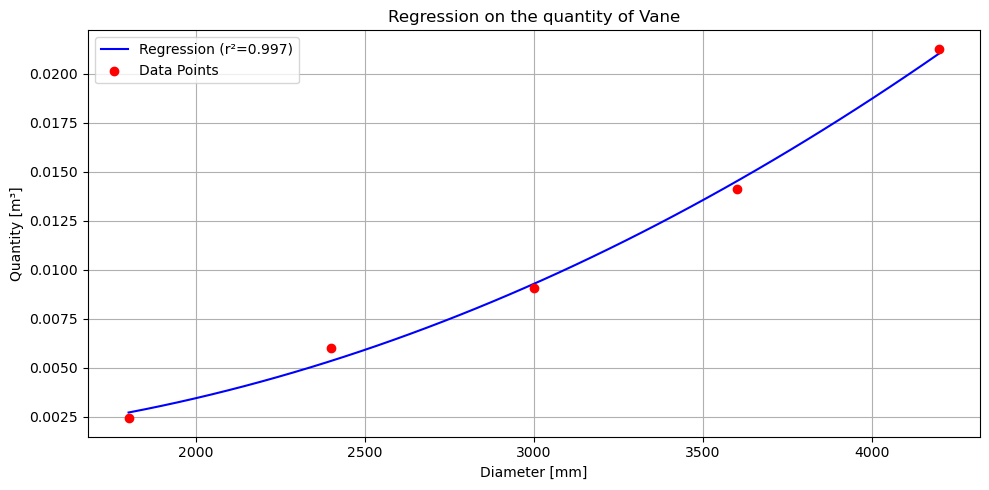

In [126]:
elem = 'Vane' #Change the name to plot other elements
# Plotting
r = element_df.loc[elem][:5]
r2 = regression_df.loc[elem]['r2']
v_coeff = regression_df.loc[elem].iloc[0]
diam_range = np.linspace(min(diam), max(diam), 50)
x_vals =diam_range
y_vals = np.polyval(v_coeff,x_vals)
plt.figure(figsize=(10, 5))
plt.plot(x_vals, y_vals, label=f"Regression (r²={round(r2,3)})", color='blue')
plt.scatter(diam,r.values , color='red', label="Data Points", zorder=5)
plt.xlabel("Diameter [mm]")
plt.ylabel(f"Quantity [{element_df.loc[elem]['unit']}]")
plt.title(f"Regression on the quantity of {elem}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Activities

In [127]:
#System 
strc = "Structure"
wg = "Windgenerator"


#Subsystem structure
rigging = "Rigging"
mast = "Mast"
fundation = "Fundation"
elec = "Electronics"

#Subsystem wind generator
prop = "Propeller"
stat = "Stator"
rot = "Rotor"
hub = "Hub"
tail = "Tail"
nac = "Nacelle"
hard = "Hardware"
oth = "Other elements"


#Materials

cable = "Cable"
conc = "Concrete"
copper = "Copper"
ix = "inox"
mgn = "Magnet"
resin = "Resin"
steel = "Steel"
wood = "Wood"
zc_c = "Zinc coating"



## Steel mix

In [128]:
steel_un_converter_ecovinent=agb.findTechAct("steel production, converter, unalloyed","RER")
steel_low_converter_ecovinent = agb.findTechAct("steel production, converter, low-alloyed","RER")
steel_low_elec_ecovinent = agb.findTechAct("steel production, electric, low-alloyed","Europe without Switzerland and Austria")

steel_un_mix = agb.newActivity(
     DB_SYST,
    "Production of unalloyed steel in Europe",
    unit = "kg",
    exchanges = {
        steel_un_converter_ecovinent : 0.55,
        steel_low_elec_ecovinent : 0.45,
    })

steel_low_mix = agb.newActivity(
     DB_SYST,
    "Production of low alloyed steel in Europe",
    unit = "kg",
    exchanges = {
        steel_low_converter_ecovinent : 0.55,
        steel_low_elec_ecovinent : 0.45,
    })

steel_un_choice = agb.newSwitchAct(
                    DB_SYST, # Database where the new activity is created
                    "Choice of mix for steel unalloyed production",
                    steel_mix, #enum parameter that is used to switch the activity
                            {
                                "Converter":steel_un_converter_ecovinent,
                                "Converter_elec": steel_un_mix,
                            })

steel_low_choice = agb.newSwitchAct(
                    DB_SYST, # Database where the new activity is created
                    "Choice of mix for steel lowalloyed production",
                    steel_mix, #enum parameter that is used to switch the activity
                            {
                                "Converter":steel_low_converter_ecovinent,
                                "Converter_elec": steel_low_mix,
                            })


steel_un = agb.newActivity(
    DB_SYST,
    "steel, unalloyed",
    unit = "kg",
    exchanges = {
        steel_un_choice : 1
    })

steel_low = agb.newActivity(
    DB_SYST,
    "steel, lowallyed",
    unit = "kg",
    exchanges = {
        steel_low_choice :1
    })


## Structure

### Fundation

In [129]:
concrete_ecoinvent = agb.findTechAct("concrete, all types to generic market for concrete, normal strength","RoW")


Concrete = agb.newActivity(
    DB_SYST,
    "concrete fondation",
    unit = "m³",
    subsystem = fundation,
    element = "concrete",
    material = conc,
    exchanges = {
        concrete_ecoinvent : 1,
    })

In [130]:
Reinforced_steel_ecoinvent = agb.findTechAct("reinforcing steel production","Europe without Austria")

Reinforced_steel = agb.newActivity(
    DB_SYST,
    "Reinforced steel",
    unit = "kg",
    material = steel,
    exchanges = {Reinforced_steel_ecoinvent : 1}
    )

Rebar_HA10 = agb.newActivity(
    DB_SYST,
    "Concrete reinforcing bar HA10",
    unit = "unit",
    subsystem = fundation,
    element = "rebar",
    exchanges = {
        Reinforced_steel : np.polyval(rebar_coeff,h),
    })

In [131]:
zinc_coating_ecoinvent = agb.findTechAct("zinc coating, pieces","RER")


zinc_coating = agb.newActivity(
    DB_SYST,
    "Zinc coating",
    unit = "m²",
    material = zc_c,
    exchanges = {zinc_coating_ecoinvent : 1}
    )

Anchor_unzinc = agb.newActivity(
    DB_SYST,
    "Anchor, not galvanised",
    unit = "unit",
    exchanges = {
        Reinforced_steel : 8.5 *1.578,
    })

Anchor = agb.newActivity(
    DB_SYST,
    "Anchor, galvanised",
    unit = "unit",
    subsystem = fundation,
    element = "anchor",
    exchanges = {
        Anchor_unzinc : 1,
        zinc_coating : np.pi*8.5*0.016
    })

In [132]:
fundation_total = agb.newActivity(
    DB_SYST,
    "Fundation",
    unit = "unit",
    exchanges = {
        Concrete : conc_fitted_model,
        Rebar_HA10 : 1,
        Anchor : 1,
        
    })

### Mast

In [133]:
drawing_of_pipe = agb.findTechAct("drawing of pipe, steel","RER")

steel_tube = agb.newActivity(
    DB_SYST,
    name="Steel tube",
    unit="kg",
    subsystem = mast,
    element = "steel tube",
    material = steel,
    exchanges = {
        steel_un : 1,
        drawing_of_pipe : 1,
    })


In [134]:
av_work_steel = agb.findTechAct("metal working, average for steel product manufacturing","RER")


swivel_pin_unzinc = agb.newActivity(
    DB_SYST,
    name="Threaded rod , not galvanised, for the swivel pin",
    unit="unit",
    material = steel,
    exchanges = {
        steel_low : rho_steel*np.pi*0.018**2/4*1,
        av_work_steel: rho_steel*np.pi*0.018**2/4*1,
    })

swivel_pin = agb.newActivity(
    DB_SYST,
    name="Threaded rod galvanised for the swivel pin",
    unit="unit",
    subsystem = mast,
    element = "swiwel_pin",
    exchanges = {
        swivel_pin_unzinc:1,
        zinc_coating : np.pi*0.018*1,    
    })

In [135]:
gusset = agb.newActivity(
    DB_SYST,
    name="Gussets",
    unit="kg",
    subsystem = mast,
    element = "gussets",
    material = steel,
    exchanges = {
        steel_un : 1,
    })

In [136]:
base = agb.newActivity(
    DB_SYST,
    name="Mast base",
    unit="unit",
    subsystem = mast,
    element = "base",
    material = steel,
    exchanges = {
        steel_un : rho_steel*1*0.1*0.01+rho_steel*1*0.06*0.008*2,
    })

In [137]:
welding_ecoinvent = agb.findTechAct("welding, arc, steel","RER")

welding = agb.newActivity(
    DB_SYST,
    name="Arc welding",
    unit="m",
    subsystem = mast,
    element = "welding",
    material = steel,
    exchanges = {
        welding_ecoinvent : 1,
    })

In [138]:
mast_total = agb.newActivity(
    DB_SYST,
    name="Mast of height h",
    unit="unit",
    exchanges = {
        steel_tube : tower_steel_tube_mass(h),
        swivel_pin : 1,
        gusset : rho_steel*(0.113*h + 0.68)*0.05*0.008,
        base : 1,
        welding : 5,
        
    })

### Rigging

In [139]:
hardware_unzinc_rigging = agb.newActivity(
    DB_SYST,
    "Hardware for rigging, not galvanised",
    unit = "unit",
    material = steel,
    exchanges = { 
        steel_low : 0.92*h+1.28,
        av_work_steel : 0.92*h+1.28,
        
    })

hardware_zinc_rigging = agb.newActivity(
    DB_SYST,
    "Hardware for rigging, galvanised",
    unit = "unit",
    subsystem = rigging,
    element = "hardware",
    exchanges = { 
       hardware_unzinc_rigging : 1,
       zinc_coating : 0.0552*h+0.0771
    })



In [140]:
steel_wire_drawing = agb.findTechAct("wire drawing, steel","RER")

guy_wire_unzinc = agb.newActivity(
    DB_SYST,
    "Guy wires, not galvanised",
    unit = "unit",
    material = steel,
    exchanges = { 
        steel_un : mass_wire_steel(h),
        steel_wire_drawing : mass_wire_steel(h),
    })

guy_wire = agb.newActivity(
    DB_SYST,
    "Guy wires, galvanised",
    unit = "unit",
    subsystem = rigging,
    element = "guy wires",
    exchanges = { 
       guy_wire_unzinc : 1,
        zinc_coating : A*lenght_wire_steel_regression(h),
    })

In [141]:
guy_wire_distributor = agb.newActivity(
    DB_SYST,
    "Guy wires distributors",
    unit = "unit",
    subsystem = rigging,
    element = "distributor",
    material = steel,
    exchanges = { 
        steel_low : rho_steel*0.15*0.008*1.2,
    })

In [142]:
rigging_total = agb.newActivity(
    DB_SYST,
    "Rigging",
    unit = "unit",
    exchanges = { 
        hardware_zinc_rigging : 1,
        guy_wire : 1,
        guy_wire_distributor : 1,
    })

### Cable 48V

Modelling of the cable come from the work of A.Prévost

In [143]:
copper_cathode = agb.findTechAct("market for copper, cathode","GLO")
copper_wire_drawing = agb.findTechAct("wire drawing, copper","RER")

copper_wire = agb.newActivity(
    DB_SYST,
    "Copper wires for cable",
    unit ="unit/m",
    exchanges = {
        copper_cathode : 8960*3*0.000004,
        copper_wire_drawing : 8960*3*0.000004,
    })

In [144]:
polyethylene = agb.findTechAct("polyethylene production, high density, granulate","RER")
extrusion_plastic = agb.findTechAct("extrusion, plastic pipes","RER")
machine = agb.findTechAct("rolling mill production","RER")
Tap_water = agb.findTechAct("market for tap water","Europe without Switzerland")

plastic = agb.newActivity(
    DB_SYST,
    "Plastic cover",
    unit = "unit/m",
    exchanges = {
        polyethylene : 0.011848,
        extrusion_plastic : 0.011848,
        machine : 0.000000000021234/h,
        Tap_water : 17.424/12,
    })

In [145]:
cable_48V = agb.newActivity(
    DB_SYST,
    "Cable 48V",
    unit='unit/m',
    subsystem = elec,
    material = cable,
    exchanges = {
        copper_wire : 1,
        plastic : 1,
    })

### Complete structure

In [146]:
structure = agb.newActivity(
    DB_SYST,
    name="Complete structure",
    unit="unit",
    system = strc,
    exchanges = {
        fundation_total : 1,
        mast_total : 1,
        rigging_total : 1,
        cable_48V : h,
    })



## Wind generator

### Propeller

In [147]:
swood=agb.findActivity(name = "planing, beam, softwood, u=20%",loc = "Europe without Switzerland",db_name = "ecoinvent-3.8-cutoff",unit ="kilogram")
plywood = agb.findActivity(name = "plywood production",loc = "RER",db_name = "ecoinvent-3.8-cutoff", unit ="cubic meter")


propeller = agb.newActivity(
    DB_SYST,
    name="Propeller",
    unit="unit",
    subsystem = prop,
    material = wood,
    exchanges = {
        swood : np.polyval(regression_df.loc['Blades'].iloc[0],d),
        plywood :  np.polyval(regression_df.loc['BladesAttachement'].iloc[0],d)*1e-6,
    })

### Stator

The inventory for the copper coils come from the study Nordelöf, A., Tillman, AM. A scalable life cycle inventory of an electrical automotive traction machine—Part II: manufacturing processes. Int J Life Cycle Assess 23, 295–313 (2018). https://doi.org/10.1007/s11367-017-1309-8

In [148]:
sheet_rolling = agb.findTechAct("sheet rolling, copper","RER")
resin_enam = agb.findTechAct("polyester resin production, unsaturated","RER")
xylene = agb.findTechAct("xylene production","RER")
elec = agb.findTechAct("market group for electricity, medium voltage","RER")

enamelling = agb.newActivity(
    DB_SYST,
    "Enamelling copper coil",
    unit = "unit/kg",
    material = resin,
    exchanges = { 
        resin_enam : 0.043,
        xylene : 0.023,
        elec :0.5
    })


copper_wire = agb.newActivity(
    DB_SYST,
    "Copper coil",
    unit = "kg",
    material = copper,
    exchanges = { 
        copper_cathode :1,
        sheet_rolling : 1,
        copper_wire_drawing : 1
    })

copper_coil = agb.newActivity(
    DB_SYST,
    "Copper coil,enamelled",
    unit = "unit",
    subsystem = stat,
    exchanges = { 
        copper_wire : np.polyval(regression_df.loc['CopperCoils'].iloc[0],d)*0.96, # 4% of the weight is assumed to be the enamelling
        enamelling : np.polyval(regression_df.loc['CopperCoils'].iloc[0],d),
    })

In [149]:
iso_resin = agb.findTechAct("isophthalic acid based unsaturated polyester resin production","RER")
talc = agb.findTechAct("steatite quarry operation","RoW")
glass_fibre = agb.findTechAct("glass fibre production","RER")

def resinS_mass(d) : return np.polyval(regression_df.loc['ResinStator'].iloc[0],d)
def resinR_mass(d) : return np.polyval(regression_df.loc['ResinRotor'].iloc[0],d)


def talc_mass(x) : #Estimation of the mass of talc as a function of the mass of resin
    return 0.45*x

def glass_fibre_mass(d): #Regression of the area of glass fibre as a function of the mass of resin
    mtot = resinR_mass(d)+resinS_mass(d)
    return (-3.1+2.03*mtot+(-0.162)*mtot**2)/mtot*sm_glassfibre
    
resin_stator = agb.newActivity(
    DB_SYST,
    "Resin for the stator",
    unit = "unit",
    subsystem = stat,
    material = resin,
    exchanges = {
        iso_resin : resinS_mass(d),
        talc : talc_mass (resinS_mass(d)),
        glass_fibre : glass_fibre_mass (d)*resinS_mass(d),
    })

In [150]:
stator = agb.newActivity(
    DB_SYST,
    "Stator",
    unit = "unit",
    exchanges = {
        copper_coil : 1,
        resin_stator : 1,
    })

### Rotor

In [151]:
metal_disk_unzinc = agb.newActivity(
    DB_SYST,
    "Metal disks, unzinc ",
    unit = "unit",
    material = steel,
    exchanges = {
        steel_un : np.polyval(regression_df.loc['MetalDisks'].iloc[0],d),
    })

metal_disk = agb.newActivity(
    DB_SYST,
    "Metal disks,galvanized ",
    unit = "unit",
    subsystem = rot,
    exchanges = {
        metal_disk_unzinc : 1,
        zinc_coating : np.polyval(regression_df.loc['SurfaceDisk'].iloc[0],d),
    })

In [152]:
mgn_neo_ecoinvent = agb.findTechAct("permanent magnet production, for electric motor","GLO") #neodym magnet

magnet = agb.newActivity(
    DB_SYST,
    "Magnet",
    unit = "unit",
    subsystem = rot,
    material = mgn,
    exchanges = {
        mgn_neo_ecoinvent : np.polyval(regression_df.loc['Magnet'].iloc[0],d)
    })

In [153]:
resin_rotor = agb.newActivity(
    DB_SYST,
    "Resin for the rotor",
    unit = "unit",
    subsystem = rot,
    material = resin,
    exchanges = {
        iso_resin : resinR_mass(d),
        talc : talc_mass (resinR_mass(d)),
        glass_fibre : glass_fibre_mass (d)*resinR_mass(d),
    })

In [154]:
rotor = agb.newActivity(
    DB_SYST,
    "Rotor",
    unit = "unit",
    exchanges = {
        metal_disk : 1,
        resin_rotor : 1,
        magnet : 1,
    })

### Hub

Hub are always collected on old cars. The impact of their fabrication are therefore not taken into account. 

### Tail

In [155]:
vane = agb.newActivity(
    DB_SYST,
    name="Vane",
    unit="unit",
    subsystem = tail,
    material = wood,
    exchanges = {
        plywood :np.polyval(regression_df.loc['Vane'].iloc[0],d) ,
    })

In [156]:
boompipe = agb.newActivity(
    DB_SYST,
    name="BoomPipe",
    unit="unit",
    subsystem = tail,
    exchanges = {
        steel_tube : np.polyval(regression_df.loc['BoomPipe'].iloc[0],d) ,
    })

In [157]:
hinge = agb.newActivity(
    DB_SYST,
    name="HingeOuter",
    unit="unit",
    subsystem = tail,
    exchanges = {
        steel_tube : np.polyval(regression_df.loc['HingeOuter'].iloc[0],d)
    })

In [158]:
othertail = agb.newActivity(
    DB_SYST,
    name="Bracket+Support+TailStop",
    unit="unit",
    subsystem = tail,
    material = steel,
    exchanges = {
        steel_low : np.polyval(regression_df.loc['Bracket+Support+TailStop'].iloc[0],d)
    })

In [159]:
tail = agb.newActivity(
    DB_SYST,
    name="Tail",
    unit="unit",
    exchanges = {
        vane : 1,
        boompipe : 1,
        hinge : 1,
        othertail : 1
    })

### Nacelle

In [160]:
def yawpipe_mass(d): return np.polyval(regression_df.loc['YawPipe'].iloc[0],d)
def yawplate_mass(d): return np.polyval(regression_df.loc['YawPlates'].iloc[0],d)

yawbearing = agb.newActivity(
    DB_SYST,
    name="Yaw Bearing",
    unit="unit",
    subsystem = nac,
    material = steel,
    exchanges = {
        steel_un : yawpipe_mass(d) + yawplate_mass(d),
        drawing_of_pipe : yawpipe_mass(d),
    })

In [161]:
frame = agb.newActivity(
    DB_SYST,
    name="Frame",
    unit="unit",
    subsystem = nac,
    material = steel,
    exchanges = {
        steel_un : np.polyval(regression_df.loc['Frame'].iloc[0],d),
    })

In [162]:
nacelle = agb.newActivity(
    DB_SYST,
    name="Nacelle",
    unit="unit",
    exchanges = {
        yawbearing : 1,
        frame : 1
    })

### Hardware

In [163]:
inox = agb.findTechAct("steel production, chromium steel 18/8, hot rolled",'RER')
av_work_inox = agb.findTechAct("metal working, average for chromium steel product manufacturing","RER")

hardware_unzinc_wg = agb.newActivity(
    DB_SYST,
    name="Hardware for wind generator, ungalvanized",
    unit="unit",
    material = steel,
    exchanges = {
        steel_low : np.polyval(regression_df.loc['Hardware zinc'].iloc[0],d),
        av_work_steel : np.polyval(regression_df.loc['Hardware zinc'].iloc[0],d),
    })

hardware_zinc_wg = agb.newActivity(
    DB_SYST,
    name="Hardware for wind generator, galvanized",
    unit="unit",
    subsystem=hard,
    exchanges = {
        hardware_unzinc_wg : 1,
        zinc_coating : np.polyval(regression_df.loc['Hardware zinc'].iloc[0],d)*60/1000
    })


hardware_inox_wg = agb.newActivity(
    DB_SYST,
    name="Hardware for wind generator, inox",
    unit="unit",
    material = ix,
    subsystem = hard,
    exchanges = {
        inox: np.polyval(regression_df.loc['Hardware inox'].iloc[0],d) ,
        av_work_inox : np.polyval(regression_df.loc['Hardware inox'].iloc[0],d)
    })

### Other elements

In [164]:
mould_stat= agb.newActivity(
    DB_SYST,
    name="Mould for the stator",
    unit="unit",
    material = wood,
    subsystem = oth,
    exchanges = {
        plywood: np.polyval(regression_df.loc['MouldStator'].iloc[0],d) ,
    })

mould_rot= agb.newActivity(
    DB_SYST,
    name="Mould for the stator",
    unit="unit",
    material = wood,
    subsystem = oth,
    exchanges = {
        plywood: np.polyval(regression_df.loc['MouldRotor'].iloc[0],d) ,
    })

moulds = agb.newActivity(
    DB_SYST,
    name="Moulds",
    unit="unit",
    exchanges = {
        mould_rot: 1/5 ,
        mould_stat : 1/5, #each mould can be use for at least 5 windturbines
    })

[WARNING] Activity 'Mould for the stator' was already in 'bdd_syst'. Overwriting it


### Complete wind generator

In [165]:
wind_generator = agb.newActivity(
    DB_SYST,
    name="Wind generator",
    unit="unit",
    system = wg,
    exchanges = {
        propeller : 1,
        rotor : 1,
        stator : 1,
        tail : 1,
        nacelle : 1,
        hardware_inox_wg : 1,
        hardware_zinc_wg : 1,
        moulds : 1,
        
    })

## Complete system

In [166]:
'''
elec = agb.findActivity(
    name = 'Electronics',
    db_name='bdd_elec')
'''

complete_system = agb.newActivity(
    db_name=DB_SYST,
    name='Complete system',
    unit="unit",
    exchanges = {
        wind_generator : 1,
        structure : 1
    })

system_recupmast = agb.newActivity(
    db_name=DB_SYST,
    name='Complete system with a 2nd use mast',
    unit="unit",
    exchanges = {
        wind_generator : 1,
        fundation_total : 1,
        rigging_total : 1,
        cable_48V : 1
    })

# LCA Results

## Inventory

In [167]:
agb.compute_inventory(wind_generator,h=12,d=2400)

[INFO] Db changed recently, clearing cache expr
[INFO] Required param 'steel_mix' was missing, replacing by default value : Converter


,database,name,location,unit,value
0,ecoinvent-3.8-cutoff,"drawing of pipe, steel",RER,kilogram,7.19477
1,ecoinvent-3.8-cutoff,glass fibre production,RER,kilogram,0.138781
2,ecoinvent-3.8-cutoff,isophthalic acid based unsaturated polyester r...,RER,kilogram,3.458
3,ecoinvent-3.8-cutoff,"market for copper, cathode",GLO,kilogram,2.83884
4,ecoinvent-3.8-cutoff,"market group for electricity, medium voltage",RER,kilowatt hour,1.47856
5,ecoinvent-3.8-cutoff,"metal working, average for chromium steel prod...",RER,kilogram,2.6156
6,ecoinvent-3.8-cutoff,"metal working, average for steel product manuf...",RER,kilogram,2.66752
7,ecoinvent-3.8-cutoff,"permanent magnet production, for electric motor",GLO,kilogram,2.0714
8,ecoinvent-3.8-cutoff,"planing, beam, softwood, u=20%",Europe without Switzerland,kilogram,21.1007
9,ecoinvent-3.8-cutoff,plywood production,RER,cubic meter,0.00671166


## Absolute impacts

In [168]:
agb.compute_impacts(complete_system, methods=[methods_EF[11],methods_EF[1],methods_EF[3],methods_EF[4],methods_EF[2]],h=12,d=2400,steel_mix = "Converter",axis = "material")

,material resources: metals/minerals - abiotic depletion potential (ADP): elements (ultimate reserves)[kg Sb-Eq],climate change - global warming potential (GWP100)[kg CO2-Eq],"energy resources: non-renewable - abiotic depletion potential (ADP): fossil fuels[MJ, net calorific value]",eutrophication: freshwater - fraction of nutrients reaching freshwater end compartment (P)[kg PO4-Eq],ecotoxicity: freshwater - comparative toxic unit for ecosystems (CTUe)[CTUe]
material,,,,,
Cable,0.0180594,9.69995,125.155,0.0591089,"6,653.86"
Concrete,0.00353767,537.245,"3,648.93",0.0667941,"7,112.5"
Copper,0.0412463,21.9798,270.372,0.135131,"15,204.7"
Magnet,0.00211849,70.2767,767.442,0.0260526,"8,922.66"
Resin,0.000207536,15.0615,328.616,0.00389442,447.388
Steel,0.00247981,515.202,"5,174.6",0.251949,"14,194.9"
Wood,3.54454e-05,4.07919,83.3042,0.00214414,156.39
Zinc_coating,0.00345023,10.284,145.168,0.00868316,"1,899.46"
_other_,0,0,0,0,0


In [169]:
agb.compute_impacts(complete_system,methods=[methods_EF[11],methods_EF[2],methods_EF[1]],h=24,d=4200,steel_mix = ['Converter','Converter_elec'])

,material resources: metals/minerals - abiotic depletion potential (ADP): elements (ultimate reserves)[kg Sb-Eq],ecotoxicity: freshwater - comparative toxic unit for ecosystems (CTUe)[CTUe],climate change - global warming potential (GWP100)[kg CO2-Eq]
steel_mix,,,
Converter,0.143932,"112,129","2,724.93"
Converter_elec,0.143826,"104,036","2,474.48"


In [170]:
agb.compute_impacts(structure,methods=[methods_EF[11],methods_EF[2],methods_EF[1]],h=18,d=2400,axis='material')

[INFO] Required param 'steel_mix' was missing, replacing by default value : Converter
[INFO] Required param 'steel_mix' was missing, replacing by default value : Converter
[INFO] Required param 'steel_mix' was missing, replacing by default value : Converter


,material resources: metals/minerals - abiotic depletion potential (ADP): elements (ultimate reserves)[kg Sb-Eq],ecotoxicity: freshwater - comparative toxic unit for ecosystems (CTUe)[CTUe],climate change - global warming potential (GWP100)[kg CO2-Eq]
material,,,
Cable,0.027089,"9,980.79",14.5499
Concrete,0.00355771,"7,152.79",540.289
Steel,0.00310184,"19,208.6",706.08
Zinc_coating,0.00255254,"1,405.26",7.60829
_other_,0,0,0
*sum*,0.0363011,"37,747.4","1,268.53"


In [171]:
agb.oat_dashboard(complete_system,[methods_EF[11],methods_EF[2],methods_EF[1]])

interactive(children=(Dropdown(description='param', options=('d', 'steel_mix', 'h'), value='d'), Output()), _d…

[INFO] Required param 'steel_mix' was missing, replacing by default value : Converter
[INFO] Required param 'steel_mix' was missing, replacing by default value : Converter
[INFO] Required param 'steel_mix' was missing, replacing by default value : Converter


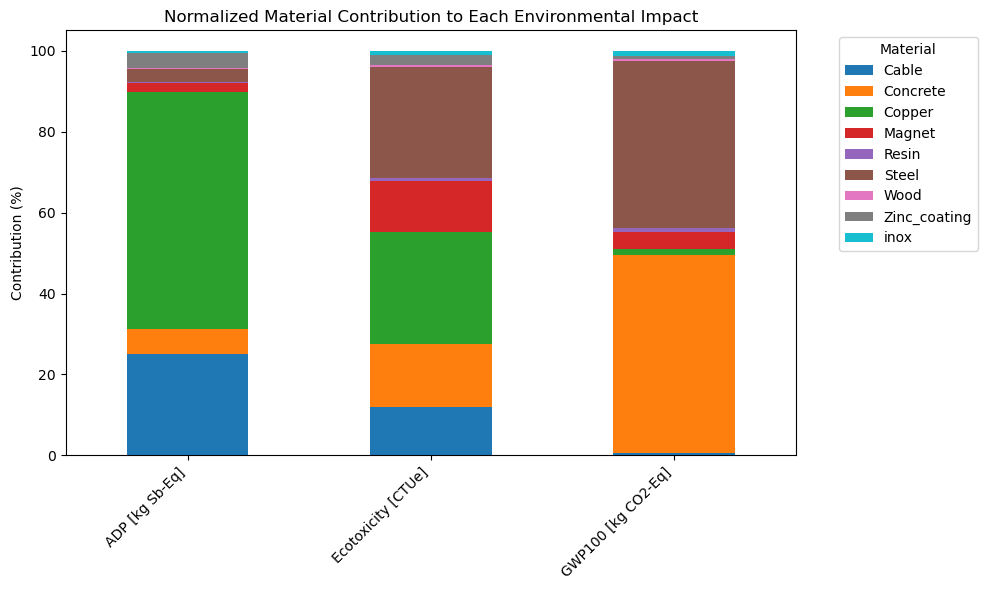

In [172]:
abs_impact = agb.compute_impacts(complete_system,axis = 'material',methods=[methods_EF[11],methods_EF[2],methods_EF[1]],h=24,d=4200).drop(index=['*sum*'])
abs_impact.columns = ['ADP [kg Sb-Eq]', 'Ecotoxicity [CTUe]', 'GWP100 [kg CO2-Eq]']

# Normalize each column (impact) so it sums to 100%
abs_impact_normalized = abs_impact.div(abs_impact.sum(axis=0), axis=1) * 100

# Transpose so that impacts are on the x-axis
abs_impact_normalized.T.plot(kind='bar', stacked=True, figsize=(10, 6))

# Style the plot
plt.title('Normalized Material Contribution to Each Environmental Impact')
plt.ylabel('Contribution (%)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Material', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

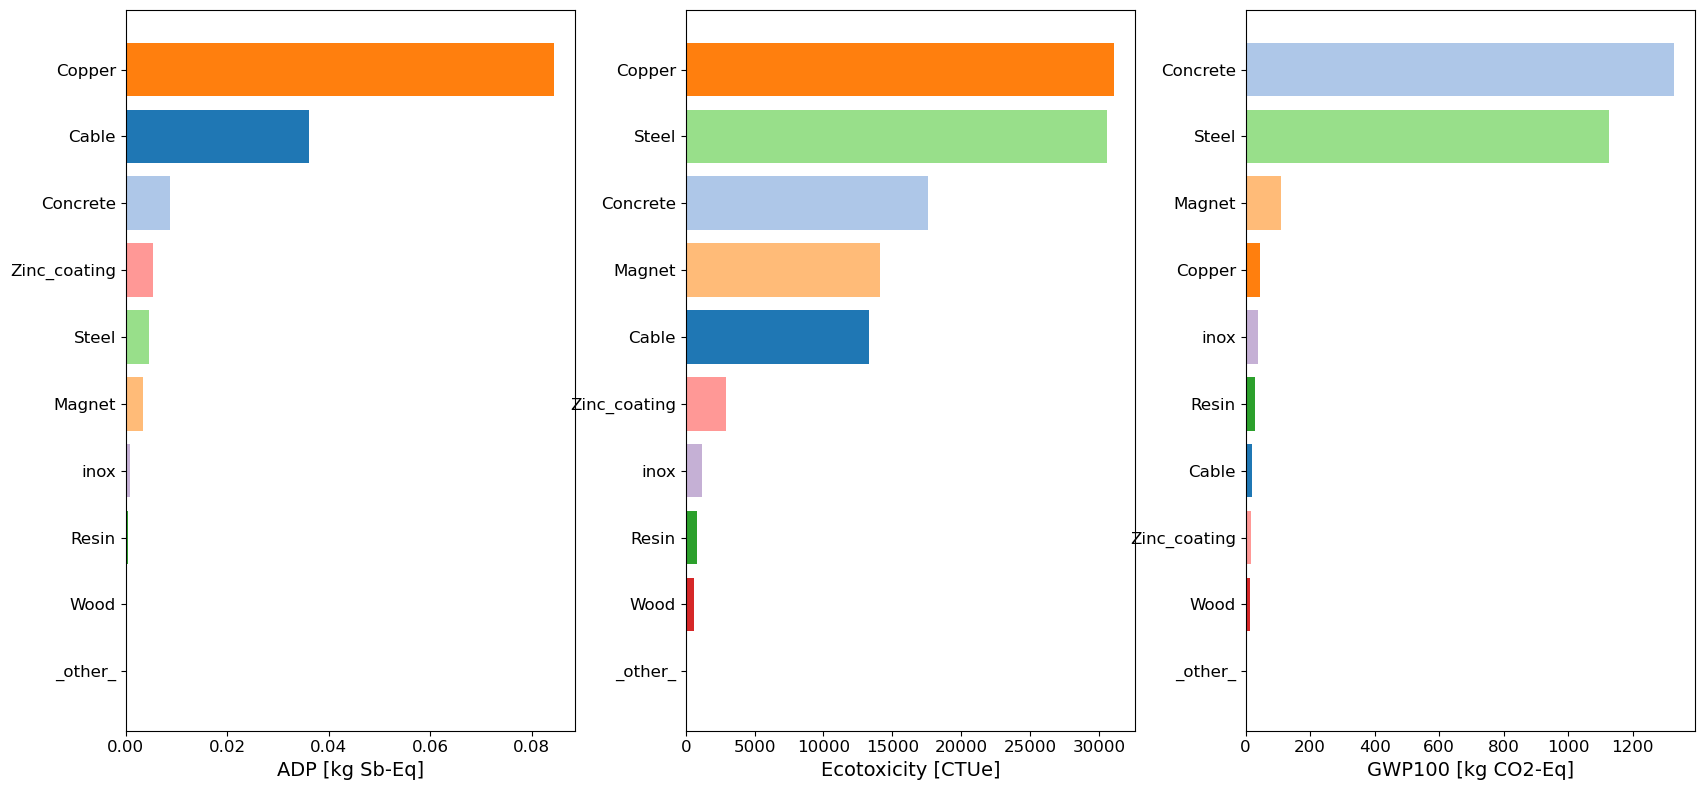

In [173]:
# Assign a consistent color per material
materials = abs_impact.index

# Use consistent color for each impact
cmap = colormaps.get_cmap('tab20')
material_colors = {mat: cmap(i) for i, mat in enumerate(materials)}

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 8), sharey=False)

# Plot each impact with its own sorting
for ax, impact in zip(axes, abs_impact.columns):
    # Sort materials by current impact
    sorted_df = abs_impact.sort_values(by=impact, ascending=False)

    # Plot with consistent colors
    ax.barh(sorted_df.index, sorted_df[impact],
            color=[material_colors[mat] for mat in sorted_df.index])
    
    ax.set_xlabel(impact, fontsize=14)
    ax.tick_params(axis='both', labelsize=12)
    ax.invert_yaxis()

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(right=0.85) 


## Impacts per functional unit

In [174]:
agb.compute_impacts(complete_system,axis = 'material',steel_mix = 'Converter',methods=[methods_EF[11],methods_EF[2],methods_EF[1]], h=24,d=4200,functional_unit=FU(d,h))

,material resources: metals/minerals - abiotic depletion potential (ADP): elements (ultimate reserves)[kg Sb-Eq],ecotoxicity: freshwater - comparative toxic unit for ecosystems (CTUe)[CTUe],climate change - global warming potential (GWP100)[kg CO2-Eq]
material,,,
Cable,6.43808e-07,0.237207,0.000345798
Concrete,1.5571e-07,0.313056,0.0236468
Copper,1.50257e-06,0.553894,0.000800707
Magnet,5.9648e-08,0.251226,0.0019787
Resin,6.56137e-09,0.0144635,0.000488517
Steel,8.3318e-08,0.545351,0.0200809
Wood,2.27971e-09,0.0101108,0.000265903
Zinc_coating,9.56767e-08,0.0526732,0.000285181
_other_,0,0,0


In [175]:
agb.compute_impacts(complete_system,methods=[methods_EF[11],methods_EF[2],methods_EF[1]],h=24,d=4200,steel_mix = ['Converter','Converter_elec'],functional_unit=FU(d,h))

,material resources: metals/minerals - abiotic depletion potential (ADP): elements (ultimate reserves)[kg Sb-Eq],ecotoxicity: freshwater - comparative toxic unit for ecosystems (CTUe)[CTUe],climate change - global warming potential (GWP100)[kg CO2-Eq]
steel_mix,,,
Converter,2.56555e-06,1.99868,0.0485712
Converter_elec,2.56367e-06,1.85442,0.044107


In [176]:
agb.compute_impacts([complete_system,system_recupmast],methods=[methods_EF[11],methods_EF[2],methods_EF[1]],h=24,d=4200,functional_unit=FU(d,h))

[INFO] Required param 'steel_mix' was missing, replacing by default value : Converter
[INFO] Required param 'steel_mix' was missing, replacing by default value : Converter
[INFO] Required param 'steel_mix' was missing, replacing by default value : Converter
[INFO] Required param 'steel_mix' was missing, replacing by default value : Converter
[INFO] Required param 'steel_mix' was missing, replacing by default value : Converter
[INFO] Required param 'steel_mix' was missing, replacing by default value : Converter


,material resources: metals/minerals - abiotic depletion potential (ADP): elements (ultimate reserves)[kg Sb-Eq],ecotoxicity: freshwater - comparative toxic unit for ecosystems (CTUe)[CTUe],climate change - global warming potential (GWP100)[kg CO2-Eq]
Complete system,2.56555e-06,1.99868,0.0485712
Complete system with a 2nd use mast,1.9137e-06,1.44231,0.0357533


In [177]:
agb.oat_dashboard(complete_system, [methods_EF[11],methods_EF[2],methods_EF[1]],functional_unit=FU(d,h))

interactive(children=(Dropdown(description='param', options=('d', 'steel_mix', 'h'), value='d'), Output()), _d…

In [178]:
agb.incer_stochastic_dashboard(complete_system, [methods_EF[11],methods_EF[2],methods_EF[1]])

Generating samples ...
Transforming samples ...
Processing Sobol indices ...
Processing sobol for ('EF v3.0', 'material resources: metals/minerals', 'abiotic depletion potential (ADP): elements (ultimate reserves)')
Processing sobol for ('EF v3.0', 'ecotoxicity: freshwater', 'comparative toxic unit for ecosystems (CTUe)')
Processing sobol for ('EF v3.0', 'climate change', 'global warming potential (GWP100)')


## Single score

In [179]:
# EF3.0 normalisation factors 
EF_NF={
    methods_EF[0][1]:5.56E+01,
    methods_EF[1][1]:8.10E+03,
    methods_EF[2][1]:4.27E+04,
    methods_EF[3][1]:6.50E+04,
    methods_EF[4][1]:1.61E+00,
    methods_EF[5][1]:1.95E+01,
    methods_EF[6][1]:1.77E+02,
    methods_EF[7][1]:1.69E-05,
    methods_EF[8][1]:2.30E-04,
    methods_EF[9][1]:4.22E+03,
    methods_EF[10][1]:8.19E+05,
    methods_EF[11][1]:6.36E-02,
    methods_EF[12][1]:5.36E-02,
    methods_EF[13][1]:5.95E-04,
    methods_EF[14][1]:4.06E+01,
    methods_EF[15][1]:1.15E+04,
        }
# EF3.0 Weighing factors 
EF_WF={
    methods_EF[0][1]:6.20E-02,
    methods_EF[1][1]:21.06E-02,
    methods_EF[2][1]:1.92E-02,
    methods_EF[3][1]:8.32E-02,
    methods_EF[4][1]:2.80E-02,
    methods_EF[5][1]:2.96E-02,
    methods_EF[6][1]:3.71E-02,
    methods_EF[7][1]:2.13E-02,
    methods_EF[8][1]:1.84E-02,
    methods_EF[9][1]:5.01E-02,
    methods_EF[10][1]:7.94E-02,
    methods_EF[11][1]:7.55E-02,
    methods_EF[12][1]:6.31E-02,
    methods_EF[13][1]:8.96E-02,
    methods_EF[14][1]:4.78E-02,
    methods_EF[15][1]:8.51E-02,
        }

NF = np.array([EF_NF[method[1]] for method in methods_EF])
WF = np.array([EF_WF[method[1]] for method in methods_EF])


In [180]:
def lca_single_score(df, NF, WF):
    """
    Parameters:
    - df: Pandas DataFrame where rows are materials and columns are impact categories.
          Assumes the last row (optional) is "*sum*", otherwise all rows are considered.
    - NF: NumPy array of normalization factors (must match df columns)
    - WF: NumPy array of weighting factors (same length as NF)

    Returns:
    - single_score: float, final normalized and weighted impact score
    - normalized: normalized impact values (NumPy array)
    - weighted: weighted impact values (NumPy array)
    """
    df_clean = df.loc[~df.index.str.startswith(('*sum*'))]


    # Normalize and weight
    normalized_df = df_clean / NF
    weighted_df = normalized_df * WF
    single_score = weighted_df.values.sum()
    return normalized_df, weighted_df,single_score

### Most important impacts

In [181]:
def most_important_impacts (lca_df) :
    impact = lca_df.columns
    score = lca_single_score((lca_df), NF, WF)
    
    impact_df = pd.DataFrame({"Impact":impact,"Values": score[1].sum(axis=0).values})
    impact_df = impact_df.sort_values(by="Values", ascending=False)
    impact_df.reset_index(drop=True, inplace=True)
    
    impact_df["Cumulative Sum"] = impact_df["Values"].cumsum()
    impact_df["Cumulative %"] = impact_df["Cumulative Sum"] / score[2]
    impact_df["% of the single score"] = impact_df['Values']/score[2]*100
    
    # Filter to rows that contribute to <= 90%
    cutoff_index = impact_df[impact_df["Cumulative %"] > 0.90].index.min()
    impact90_df = impact_df.loc[:cutoff_index]
    return impact90_df
impact90_df = most_important_impacts(agb.compute_impacts(complete_system,axis = 'material',methods=methods_EF,h=24,d=4200, steel_mix='Converter'))
impact90 = impact90_df["Impact"]
impact3 = impact90[:3]
impact90_df

,Impact,Values,Cumulative Sum,Cumulative %,% of the single score
0,material resources: metals/minerals - abiotic ...,0.170862,0.170862,0.384686,38.4686
1,climate change - global warming potential (GWP...,0.0708481,0.24171,0.544197,15.951
2,ecotoxicity: freshwater - comparative toxic un...,0.0504188,0.292129,0.657712,11.3515
3,energy resources: non-renewable - abiotic depl...,0.0304364,0.322565,0.726237,6.85257
4,particulate matter formation - impact on human...,0.0238404,0.346406,0.779913,5.36754
5,eutrophication: freshwater - fraction of nutri...,0.0208267,0.367233,0.826803,4.689
6,acidification - accumulated exceedance (ae)[mo...,0.0169288,0.384161,0.864917,3.81143
7,photochemical ozone formation: human health - ...,0.0127382,0.3969,0.893596,2.86792
8,human toxicity: carcinogenic - comparative tox...,0.0113178,0.408217,0.919078,2.54815


### Contribution to single score

[INFO] Required param 'steel_mix' was missing, replacing by default value : Converter
[INFO] Required param 'steel_mix' was missing, replacing by default value : Converter
[INFO] Required param 'steel_mix' was missing, replacing by default value : Converter
[INFO] Required param 'steel_mix' was missing, replacing by default value : Converter
[INFO] Required param 'steel_mix' was missing, replacing by default value : Converter
[INFO] Required param 'steel_mix' was missing, replacing by default value : Converter
[INFO] Required param 'steel_mix' was missing, replacing by default value : Converter
[INFO] Required param 'steel_mix' was missing, replacing by default value : Converter
[INFO] Required param 'steel_mix' was missing, replacing by default value : Converter
[INFO] Required param 'steel_mix' was missing, replacing by default value : Converter
[INFO] Required param 'steel_mix' was missing, replacing by default value : Converter
[INFO] Required param 'steel_mix' was missing, replaci

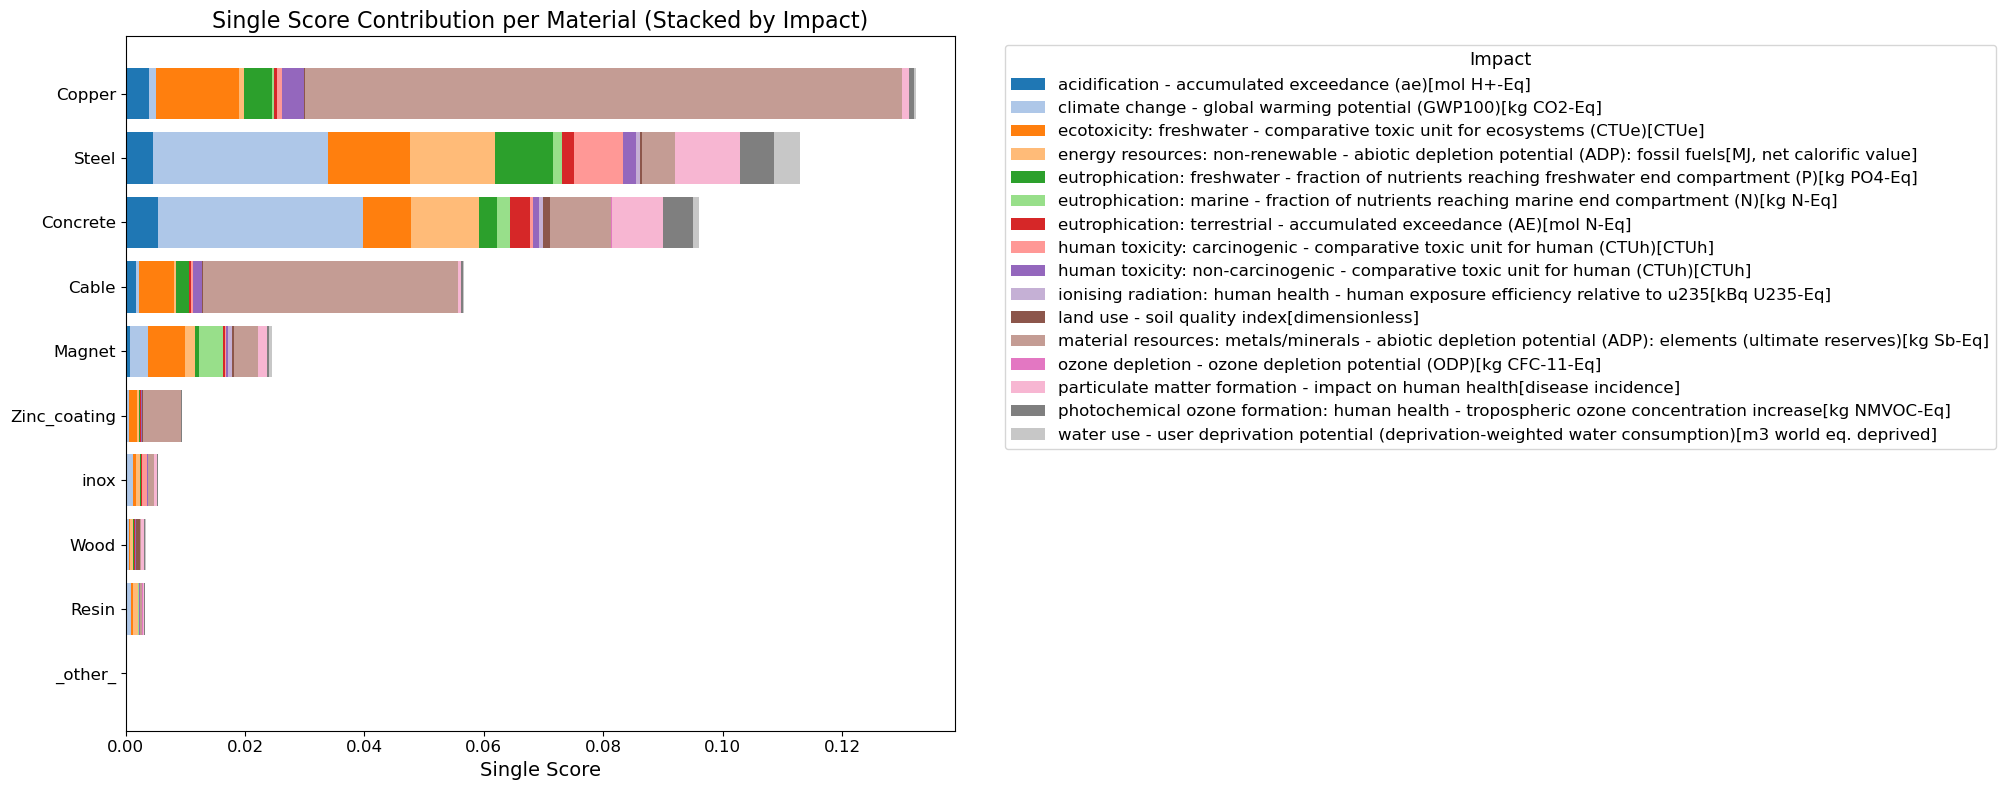

In [182]:
weighted_df = lca_single_score(agb.compute_impacts(complete_system,methods_EF,axis='material',d=4200,h=24), NF, WF)[1]
weighted_df = weighted_df.loc[weighted_df.sum(axis=1).sort_values(ascending=True).index]  

fig, ax = plt.subplots(figsize=(12, 8))


impact_colors = {impact: cmap(i) for i, impact in enumerate(weighted_df.columns)}

# Plot stacked bars
bottom = pd.Series([0] * len(weighted_df), index=weighted_df.index)
for impact in weighted_df.columns:
    ax.barh(weighted_df.index, weighted_df[impact],
            left=bottom,
            label=impact,
            color=impact_colors[impact])
    bottom += weighted_df[impact]

# Style
ax.set_title("Single Score Contribution per Material (Stacked by Impact)", fontsize=16)
ax.set_xlabel("Single Score", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
plt.legend(title='Impact', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=13)
plt.tight_layout()
plt.subplots_adjust(right=0.8)
plt.show()


# Optimization

## Minimization of the single score

In [89]:
from noload.analyse.simulation import computeOnce


def impact_1score (diameter, height) :  
    diameter = float(diameter)
    height = float(height)
    
    impact = agb.compute_impacts(complete_system,methods_EF, h= height,d = diameter,steel_mix = 'Converter',functional_unit=FU(diameter, height))
    s_score = lca_single_score(impact, NF, WF)[2]
    aep = FU_numeric(diameter, height)
    return locals().items()

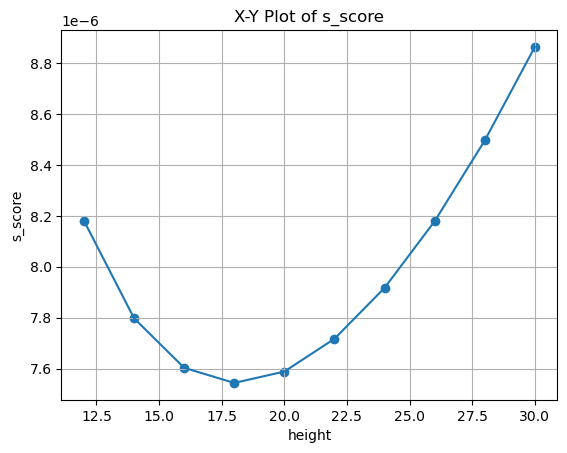

In [90]:
from noload.analyse.simulation import computeParametric
inputs={'diameter':4200}
variable = 'height'
values = np.linspace (12,30,10)
outputs=['s_score']

iter = computeParametric (impact_1score,variable,values,inputs,outputs)
iter.plotXY()



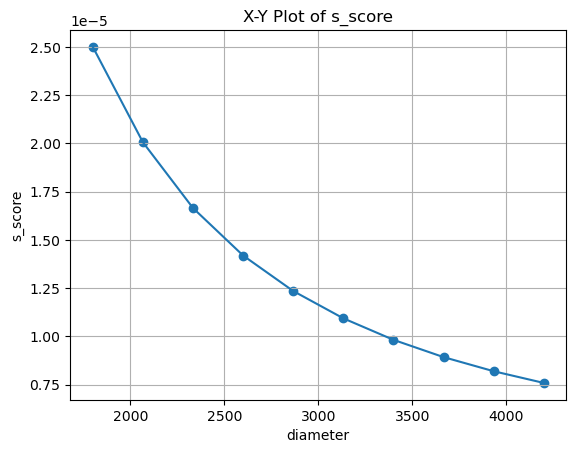

In [91]:
from noload.analyse.simulation import computeParametric
inputs={'height':20}
variable = 'diameter'
values = np.linspace (1800,4200,10)
outputs=['s_score']

iter = computeParametric (impact_1score,variable,values,inputs,outputs)
iter.plotXY()



Optimization terminated successfully. 	(Exit mode 0)
			Current function value: 7.546392649536665e-06
			Iterations: 13
{'height': 18.00539214138804, 'diameter': 4198.578307213917}
{'s_score': 7.546392601756191e-06}


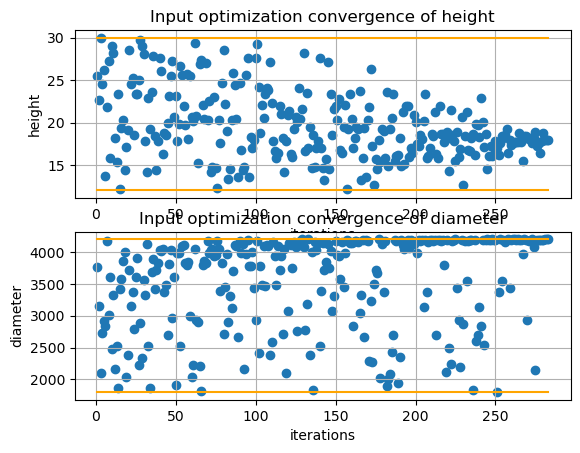

In [92]:
from noload.optimization.optimProblem import Spec, OptimProblem


spec_Sscore = Spec(variables={'height':15.0,'diameter':2400}, bounds={'height': [12, 30],'diameter':[1800,4200]},
            objectives={'s_score':[0,1]})
optim_Sscore = OptimProblem(model = impact_1score,specifications = spec_Sscore)
result_Sscore = optim_Sscore.run(ftol = 1e-8, method = 'stochastic')

result_Sscore.printResults()
result_Sscore.plotResults()

### Optimal need

In [188]:
from noload.optimization.optimProblem import Spec, OptimProblem

v_ref = 5.0
z0 = 0.5
v=int(v_ref)
z = int(z0*10)

annual_needs = [600, 1100, 1600, 2100, 2600, 3100, 3600, 4100, 4600,5100,5600]


result_optimneed_df = pd.DataFrame(columns=['h','d','NrjNeed','Production','SingleScore'])

for annual_need in annual_needs : 
    nrj_need = annual_need*lifetime
    spec_Sscore_nrjneed = Spec(variables={'height':15.0,'diameter':2400}, bounds={'height': [12, 30],'diameter':[1800,4200]},
                objectives={'s_score':[0,1]}, ineq_cstr={'aep':[nrj_need*0.95,nrj_need*1.05]})
    optim_Sscore_nrjneed = OptimProblem(model = impact_1score,specifications = spec_Sscore_nrjneed)
    result_Sscore_nrjneed = optim_Sscore_nrjneed.run(ftol = 1e-7, method = 'stochastic')
    h_opt = result_Sscore_nrjneed.getLastInputs()['height']
    d_opt = result_Sscore_nrjneed.getLastInputs()['diameter']
    score_opt = result_Sscore_nrjneed.getLastOutputs()['s_score']
    prod_opt = result_Sscore_nrjneed.getLastOutputs()['aep']

    result_optimneed_df.loc[len(result_optimneed_df)] = [h_opt, d_opt, nrj_need, prod_opt, score_opt]
result_optimneed_df.to_excel(f"/home/raphael/Documents/PFE/Sortie simu/optimneed_{v}_0{z}.xlsx")
result_optimneed_df


Optimization terminated successfully. 	(Exit mode 0)
			Current function value: 1.4329281176710131e-05
			Iterations: 20
Optimization terminated successfully. 	(Exit mode 0)
			Current function value: 9.286024481841607e-06
			Iterations: 21
Optimization terminated successfully. 	(Exit mode 0)
			Current function value: 7.280062139668119e-06
			Iterations: 18
Optimization terminated successfully. 	(Exit mode 0)
			Current function value: 6.170633605670882e-06
			Iterations: 15
Optimization terminated successfully. 	(Exit mode 0)
			Current function value: 5.4579370967613e-06
			Iterations: 9
Optimization terminated successfully. 	(Exit mode 0)
			Current function value: 4.9531939736338546e-06
			Iterations: 9
Optimization terminated successfully. 	(Exit mode 0)
			Current function value: 4.569290598935819e-06
			Iterations: 15
Optimization terminated successfully. 	(Exit mode 0)
			Current function value: 4.34980954089131e-06
			Iterations: 22
Optimization terminated successfully. 	(Exi

,h,d,NrjNeed,Production,SingleScore
0,12.0156,"1,810.63","12,000","12,599.8",1.43293e-05
1,12.1234,"2,444.51","22,000","23,100",9.28602e-06
2,12.5112,"2,918.47","32,000","33,599.4",7.28006e-06
3,13.0021,"3,303.15","42,000","44,099.9",6.17063e-06
4,13.6689,"3,616.76","52,000","54,529.3",5.45794e-06
5,14.0131,"3,918.4","62,000","64,975.9",4.95319e-06
6,14.4108,"4,190.93","72,000","75,583.2",4.56929e-06
7,18.0337,"4,198.61","82,000","86,095.7",4.34981e-06
8,19.574,"4,197.07","92,000","89,834",4.33733e-06
9,22.9659,"4,196.82","102,000","97,331.4",4.41617e-06


In [122]:
from noload.optimization.optimProblem import Spec, OptimProblem

all_results_optim_dict = {}
annual_needs = [400, 800, 1200, 1600, 2000, 2400, 2800, 3200, 3600]

for v in [4,5]:
    for z in [1,3,5] :
        v_ref = float(v)
        z0 = float(z)/10
        result_optimneed_df = pd.DataFrame(columns=['h','d','NrjNeed','Production','SingleScore'])

        for annual_need in annual_needs : 
            nrj_need = annual_need*lifetime
            spec_Sscore_nrjneed = Spec(variables={'height':15.0,'diameter':2400}, bounds={'height': [12, 30],'diameter':[1800,4200]},
                        objectives={'s_score':[0,1]}, ineq_cstr={'aep':[nrj_need*0.95,nrj_need*1.05]})
            optim_Sscore_nrjneed = OptimProblem(model = impact_1score,specifications = spec_Sscore_nrjneed)
            result_Sscore_nrjneed = optim_Sscore_nrjneed.run(ftol = 1e-7, method = 'stochastic')
            h_opt = result_Sscore_nrjneed.getLastInputs()['height']
            d_opt = result_Sscore_nrjneed.getLastInputs()['diameter']
            score_opt = result_Sscore_nrjneed.getLastOutputs()['s_score']
            prod_opt = result_Sscore_nrjneed.getLastOutputs()['aep']
        
            result_optimneed_df.loc[len(result_optimneed_df)] = [h_opt, d_opt, nrj_need, prod_opt, score_opt]
        result_optimneed_df.to_excel(f"/home/raphael/Documents/PFE/Sortie simu/optimneed_{v}_0{z}.xlsx")
        all_results_optim_dict[(v,z/10)] = result_optimneed_df



Optimization terminated successfully. 	(Exit mode 0)
			Current function value: 2.213511018487154e-05
			Iterations: 16
{'height': 12.006454216921693, 'diameter': 1904.1415141119917}
{'s_score': 2.2135109770545014e-05, 'aep': 8363.882460675888}
Optimization terminated successfully. 	(Exit mode 0)
			Current function value: 1.364603666203429e-05
			Iterations: 19
{'height': 12.331642621719364, 'diameter': 2678.537063768328}
{'s_score': 1.3646036502881112e-05, 'aep': 16786.93061965498}
Optimization terminated successfully. 	(Exit mode 0)
			Current function value: 1.0613196876711707e-05
			Iterations: 13
{'height': 12.598725494093623, 'diameter': 3262.9361352188694}
{'s_score': 1.061319678444769e-05, 'aep': 25193.15289720839}
Optimization terminated successfully. 	(Exit mode 0)
			Current function value: 9.01733097619878e-06
			Iterations: 8
{'height': 12.8278917920386, 'diameter': 3747.5100172769558}
{'s_score': 9.017330913010893e-06, 'aep': 33544.96510666927}
Optimization terminated su

,h,d,NrjNeed,Production,SingleScore
0,12.0065,"1,904.14","8,000","8,363.88",2.21351e-05
1,12.3316,"2,678.54","16,000","16,786.9",1.3646e-05
2,12.5987,"3,262.94","24,000","25,193.2",1.06132e-05
3,12.8279,"3,747.51","32,000","33,545",9.01733e-06
4,14.1031,"4,090.52","40,000","41,937.2",8.00152e-06
5,17.3866,"4,199.14","48,000","48,824.6",7.55128e-06


In [130]:
result_optimneed_df.to_excel("/home/raphael/Documents/PFE/Sortie simu/optimneed_4_01.xlsx")

In [118]:

from noload.optimization.optimProblem import Spec, OptimProblem

nrj_need = 500*lifetime

spec_Sscore = Spec(variables={'height':15.0,'diameter':2400}, bounds={'height': [12, 30],'diameter':[1800,4200]},
            objectives={'s_score':[0,100]},
           ineq_cstr={'aep':[nrj_need-10,nrj_need+10]})
optim_Sscore = OptimProblem(model = impact_1score,specifications = spec_Sscore)
result_Sscore = optim_Sscore.run(ftol = 1e-7, method = 'stochastic')

result_Sscore.printResults()

Optimization terminated successfully. 	(Exit mode 0)
			Current function value: 1.981247186555713e-05
			Iterations: 23
{'height': 13.45520578996579, 'diameter': 2020.5975493936478}
{'s_score': 1.981247151913011e-05, 'aep': 9993.998013200764}


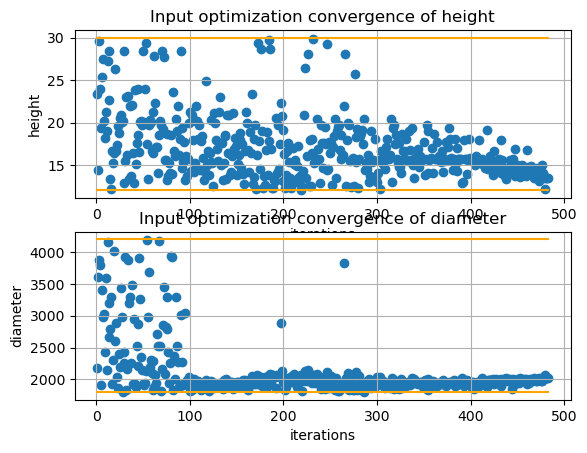

In [119]:
result_Sscore.plotResults()

## Minimization of the global warming impact

In [92]:
def impact_CO2 (diameter, height) :  
    diameter = float(diameter)
    height = float(height)
    
    impact = agb.compute_impacts(complete_system,methods_EF, h= height,d = diameter,steel_mix = "Converter",functional_unit=FU(diameter, height))
    impact_CO2 = impact['climate change - global warming potential (GWP100)[kg CO2-Eq]'].iloc[0]
    aep = FU_numeric(diameter, height)
    return locals().items()


spec_CO2 = Spec(variables={'height':15.0,'diameter':2400}, bounds={'height': [12, 30],'diameter':[1800,4200]},
            objectives={'impact_CO2':[0,1]})
optim_CO2 = OptimProblem(model = impact_CO2,specifications = spec_CO2)
result_CO2 = optim_CO2.run(ftol = 1e-7, method = 'stochastic')

result_CO2.printResults()

Optimization terminated successfully. 	(Exit mode 0)
			Current function value: 0.041353993130610917
			Iterations: 15
{'height': 16.040592638054374, 'diameter': 4199.999976}
{'impact_CO2': 0.041353993379183045}


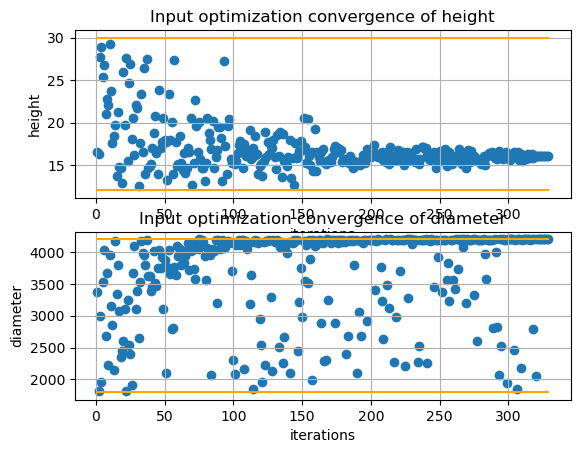

In [93]:
result_CO2.plotResults()

## Minimization of the abiotic depletion ressources

In [93]:
def impact_ADP (diameter, height) :  
    diameter = float(diameter)
    height = float(height)
    
    impact = agb.compute_impacts(complete_system,methods_EF, h= height,d = diameter,steel_mix = "Converter",functional_unit=FU(diameter, height))
    impact_ADP = impact['material resources: metals/minerals - abiotic depletion potential (ADP): elements (ultimate reserves)[kg Sb-Eq]'].iloc[0]
    aep = FU_numeric(diameter, height)
    return locals().items()


spec_ADP = Spec(variables={'height':15.0,'diameter':2400}, bounds={'height': [12, 30],'diameter':[1800,4200]},
            objectives={'impact_ADP':[0,1]})
optim_ADP = OptimProblem(model = impact_ADP,specifications = spec_ADP)
result_ADP = optim_ADP.run(ftol = 1e-7, method = 'stochastic')

result_ADP.printResults()

Optimization terminated successfully. 	(Exit mode 0)
			Current function value: 2.5666727613920425e-06
			Iterations: 7
{'height': 24.602265567852907, 'diameter': 4197.2952160960795}
{'impact_ADP': 2.566672745710972e-06}


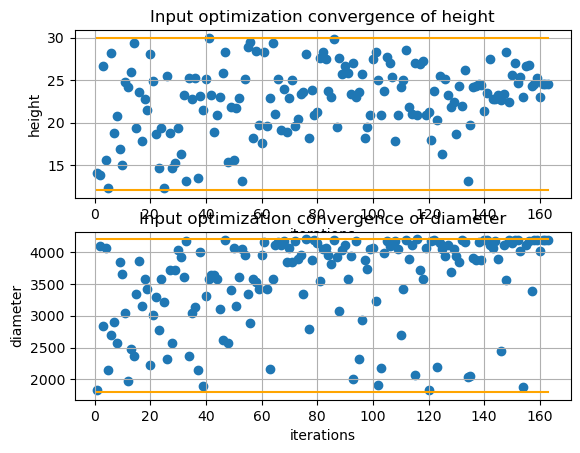

In [94]:
result_ADP.plotResults()

## Double objectif

import noload.gui.plotPareto as pp

def impact_dobj (diameter, height) :  
    diameter = float(diameter)
    height = float(height)
    
    impact = agb.compute_impacts(complete_system,methods_EF, h= height,d = diameter,steel_mix = "Converter",functional_unit=FU(diameter, height))
    impact_ADP = impact['material resources: metals/minerals - abiotic depletion potential (ADP): elements (ultimate reserves)[kg Sb-Eq]'].iloc[0]
    impact_CO2 = impact['climate change - global warming potential (GWP100)[kg CO2-Eq]'].iloc[0]
    return locals().items()

spec_dobj = Spec(variables={'height':15.0,'diameter':2400}, bounds={'height': [12, 30],'diameter':[1800,4200]},
            objectives={'impact_ADP':[0,1],'impact_CO2':[0,1]})
optim_dobj = OptimProblem(model = impact_dobj,specifications = spec_dobj)
result_dobj = optim_dobj.run(ftol = 1e-7, method = 'stochastic')

result_dobj.printResults()

inp,out=result_dobj.getIteration(400)
print('inp=',inp)
print('out=',out)

pp.plot([result_dobj.resultsHandler],['impact_ADP', 'impact_CO2'],['5points'],'Pareto Front',spec_dobj,0,True)

## Minimization of the mass per functional unit

In [100]:
def mass_system (diameter, height) :  
    diameter = float(diameter)
    height = float(height)
    
    inventory = agb.compute_inventory(complete_system, h= height,d = diameter,steel_mix = "Converter")
    mass_total = inventory[inventory['unit'] == 'kilogram']['value'].sum()
    aep = FU_numeric(diameter, height)
    mass_per_kWh = mass_total/aep
    return locals().items()


spec_mass = Spec(variables={'height':15.0,'diameter':2400}, bounds={'height': [12, 30],'diameter':[1800,4200]},
            objectives={'mass_per_kWh':[0,100]})
optim_mass = OptimProblem(model = mass_system,specifications = spec_mass)
result_mass = optim_mass.run(ftol = 1, method = 'stochastic')

result_mass.printResults()


Optimization terminated successfully. 	(Exit mode 0)
			Current function value: 0.01394201043105217
			Iterations: 1
{'height': 12.0, 'diameter': 4199.999976}
{'mass_per_kWh': 0.01394201054368728}


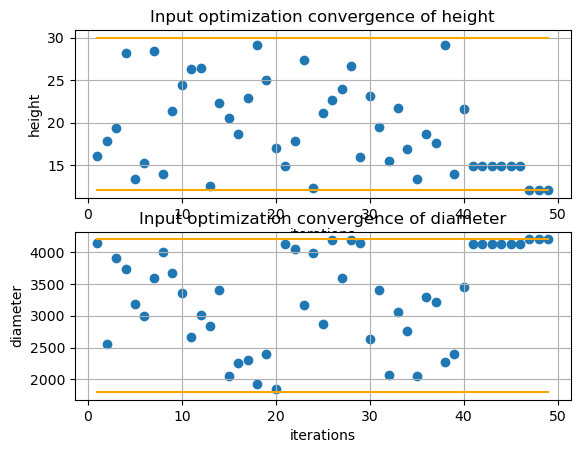

In [101]:
result_mass.plotResults()

# Back to the LCA

## LCA of the single score per functional unit optimization 

### Absolute impacts

In [96]:
h_1score = result_Sscore.getLastInputs()['height']
d_1score = result_Sscore.getLastInputs()['diameter']
min_1score_abs = agb.compute_impacts(complete_system,methods=methods_EF,h=h_1score,d=d_1score,steel_mix = 'Converter')
min_1score_abs_1score = lca_single_score(min_1score_abs,NF,WF)[2]

print("single score = ",min_1score_abs_1score)
min_1score_abs[impact3]

single score =  0.37492729041705175


,material resources: metals/minerals - abiotic depletion potential (ADP): elements (ultimate reserves)[kg Sb-Eq],climate change - global warming potential (GWP100)[kg CO2-Eq],ecotoxicity: freshwater - comparative toxic unit for ecosystems (CTUe)[CTUe]
Complete system,0.131217,"2,082.75","95,984.2"


### Impact per functional unit

In [97]:
min_1score_fu = agb.compute_impacts(complete_system,methods=methods_EF,h=h_1score,d=d_1score,steel_mix = 'Converter',functional_unit=FU(d,h))
min_1score_fu_1score = lca_single_score(min_1score_fu,NF,WF)[2]

print("single score = ",min_1score_fu_1score)
min_1score_fu[impact3]

single score =  7.543980751013409e-06


,material resources: metals/minerals - abiotic depletion potential (ADP): elements (ultimate reserves)[kg Sb-Eq],climate change - global warming potential (GWP100)[kg CO2-Eq],ecotoxicity: freshwater - comparative toxic unit for ecosystems (CTUe)[CTUe]
Complete system,2.64024e-06,0.0419075,1.93132


## LCA of the global warming per functional unit optimization 

### Absolute impacts

In [98]:
h_CO2 = result_CO2.getLastInputs()['height']
d_CO2 = result_CO2.getLastInputs()['diameter']
min_CO2_abs = agb.compute_impacts(complete_system,methods=methods_EF,h=h_CO2,d=d_CO2,steel_mix = 'Converter')
min_CO2_abs_1score = lca_single_score(min_CO2_abs,NF,WF)[2]

print("single score = ",min_CO2_abs_1score)
min_CO2_abs[impact3]

single score =  0.35763654579840104


,material resources: metals/minerals - abiotic depletion potential (ADP): elements (ultimate reserves)[kg Sb-Eq],climate change - global warming potential (GWP100)[kg CO2-Eq],ecotoxicity: freshwater - comparative toxic unit for ecosystems (CTUe)[CTUe]
Complete system,0.127371,"1,945.86","91,755.4"


### Impact per functional unit

In [99]:
min_CO2_fu = agb.compute_impacts(complete_system,methods=methods_EF,h=h_CO2,d=d_CO2, steel_mix = 'Converter', functional_unit=FU(d,h))
min_CO2_fu_1score = lca_single_score(min_CO2_fu,NF,WF)[2]

print("single score = ",min_CO2_fu_1score)
min_CO2_fu[impact3]

single score =  7.600596290586015e-06


,material resources: metals/minerals - abiotic depletion potential (ADP): elements (ultimate reserves)[kg Sb-Eq],climate change - global warming potential (GWP100)[kg CO2-Eq],ecotoxicity: freshwater - comparative toxic unit for ecosystems (CTUe)[CTUe]
Complete system,2.70692e-06,0.041354,1.95001


## LCA of abiotic depletion potential per functional unit optimization 

### Absolute impacts

In [96]:
h_ADP = result_ADP.getLastInputs()['height']
d_ADP = result_ADP.getLastInputs()['diameter']
min_ADP_abs = agb.compute_impacts(complete_system,methods=methods_EF,h=h_ADP,d=d_ADP,steel_mix = 'Converter')
min_ADP_abs_1score = lca_single_score(min_ADP_abs,NF,WF)[2]

print("single score = ",min_ADP_abs_1score)
min_ADP_abs[impact3]

single score =  0.452528511629205


,material resources: metals/minerals - abiotic depletion potential (ADP): elements (ultimate reserves)[kg Sb-Eq],climate change - global warming potential (GWP100)[kg CO2-Eq],ecotoxicity: freshwater - comparative toxic unit for ecosystems (CTUe)[CTUe]
Complete system,0.145255,"2,809.09","114,038"


### Impact per functional unit

In [98]:
min_ADP_fu = agb.compute_impacts(complete_system,methods=methods_EF,h=h_ADP,d=d_ADP, steel_mix = 'Converter', functional_unit=FU(d,h))
min_ADP_fu_1score = lca_single_score(min_ADP_fu,NF,WF)[2]

print("single score = ",min_ADP_fu_1score)
min_ADP_fu[impact3]

single score =  7.99620994208452e-06


,material resources: metals/minerals - abiotic depletion potential (ADP): elements (ultimate reserves)[kg Sb-Eq],climate change - global warming potential (GWP100)[kg CO2-Eq],ecotoxicity: freshwater - comparative toxic unit for ecosystems (CTUe)[CTUe]
Complete system,2.56667e-06,0.0496369,2.01506


## LCA of the mass per functional unit optimization 

### Absolute impacts

In [105]:
h_mass = result_mass.getLastInputs()['height']
d_mass = result_mass.getLastInputs()['diameter']
min_mass_abs = agb.compute_impacts(complete_system,methods=methods_EF,h=h_mass,d=d_mass,steel_mix = 'Converter')
min_mass_abs_1score = lca_single_score(min_mass_abs,NF,WF)[2]

print("single score = ",min_mass_abs_1score)
impact3 = most_important_impacts(min_mass_abs)["Impact"][:3]
min_mass_abs[impact3]

single score =  0.33280185904357873


,material resources: metals/minerals - abiotic depletion potential (ADP): elements (ultimate reserves)[kg Sb-Eq],climate change - global warming potential (GWP100)[kg CO2-Eq],ecotoxicity: freshwater - comparative toxic unit for ecosystems (CTUe)[CTUe]
Complete system,0.120445,"1,798.18","85,274"


### Impact per functional unit

In [103]:
min_mass_fu = agb.compute_impacts(complete_system,methods=methods_EF,h=h_mass,d=d_mass, steel_mix = 'Converter', functional_unit=FU(d,h))
min_mass_fu_1score = lca_single_score(min_mass_fu,NF,WF)[2]

print("single score = ",min_mass_fu_1score)
min_mass_fu[impact3]

single score =  8.1809277138215e-06


,material resources: metals/minerals - abiotic depletion potential (ADP): elements (ultimate reserves)[kg Sb-Eq],climate change - global warming potential (GWP100)[kg CO2-Eq],ecotoxicity: freshwater - comparative toxic unit for ecosystems (CTUe)[CTUe]
Complete system,2.96078e-06,0.0442028,2.0962


# Monte Carlo

In [120]:
h_value = h_1score
d_value = d_1score
bi.export.write_lci_excel(DB_SYST)

'/home/raphael/.local/share/Brightway3/ACV-Parametrique-mat.7ebefe1a45517f38b0684da2e4917383/output/lci-bdd_syst.xlsx'

In [124]:
import openpyxl
import os
import math

def evaluate_formula(formula, h=None, d=None):
    allowed_vars = {
        "h": h,
        "d": d,
        "pi": math.pi  # allow pi usage in formula
    }
    if not isinstance(formula, str):
        return None
    try:
        return eval(formula, {"__builtins__": None}, allowed_vars)
    except Exception as e:
        print(f"Error evaluating formula: {formula} → {e}")
        return None

def update_excel_with_results(input_path, h_val=None, d_val=None):
    wb = openpyxl.load_workbook(input_path)

    for sheet in wb.worksheets:
        # Try finding headers
        header_row = None
        for row in sheet.iter_rows(min_row=1, values_only=True):
            if row:
                headers = list(row)
                if "formula" in headers and "amount" in headers:
                    formula_idx = headers.index("formula")
                    amount_idx = headers.index("amount")
                    header_row = headers
                    break

        if header_row:
            header_row_idx = sheet.iter_rows(min_row=1, max_row=1).__next__()[0].row
            for row in sheet.iter_rows(min_row=header_row_idx + 1):
                formula_cell = row[formula_idx]
                amount_cell = row[amount_idx]

                # Evaluate only if it's a formula string
                if formula_cell.value and isinstance(formula_cell.value, str):
                    result = evaluate_formula(formula_cell.value, h=h_val, d=d_val)
                    if result is not None:
                        amount_cell.value = result

    # Save updated workbook to current working directory
    output_filename = "lci-bdd_syst_updated.xlsx"
    output_path = os.path.join(os.getcwd(), output_filename)
    wb.save(output_path)
    print(f"Updated file saved as: {output_path}")

input_file_path = bi.export.write_lci_excel(DB_SYST)
h_value = h_1score
d_value = d_1score

update_excel_with_results(input_file_path, h_val=h_value, d_val=d_value)

Error evaluating formula: minimum → 'NoneType' object is not subscriptable
Error evaluating formula: formula → 'NoneType' object is not subscriptable
Error evaluating formula: formula → 'NoneType' object is not subscriptable
Error evaluating formula: formula → 'NoneType' object is not subscriptable
Error evaluating formula: steel_mix_Converter_elec → 'NoneType' object is not subscriptable
Error evaluating formula: steel_mix_Converter → 'NoneType' object is not subscriptable
Error evaluating formula: formula → 'NoneType' object is not subscriptable
Error evaluating formula: steel_mix_Converter_elec → 'NoneType' object is not subscriptable
Error evaluating formula: steel_mix_Converter → 'NoneType' object is not subscriptable
Error evaluating formula: formula → 'NoneType' object is not subscriptable
Error evaluating formula: formula → 'NoneType' object is not subscriptable
Error evaluating formula: formula → 'NoneType' object is not subscriptable
Error evaluating formula: formula → 'NoneT

In [114]:
def multiImpactMonteCarloLCA(functional_unit, list_methods, iterations):
    # Step 1
    MC_lca = bc.MonteCarloLCA(functional_unit)
    MC_lca.lci()
    # Step 2
    C_matrices = {}
    # Step 3
    for method in list_methods:
        MC_lca.switch_method(method)
        C_matrices[method] = MC_lca.characterization_matrix
        # Step 4
        results = np.empty((len(list_methods), iterations))
    # Step 5
    for iteration in range(iterations):
        next(MC_lca)
        for method_index, method in enumerate(list_methods):
            results[method_index, iteration] = (C_matrices[method]*MC_lca.inventory).sum()
    return results

In [108]:
short_impact = [methods_EF[11],methods_EF[1],methods_EF[3],methods_EF[4],methods_EF[2]]
mc_complete_system = multiImpactMonteCarloLCA({complete_system:1},short_impact,1000)

In [109]:
plot_impacts =  ["material resources [kg Sb-Eq]",
    "climate change [kg CO2-Eq]",
    "energy resources: non-renewable [MJ, net calorific value]",
    "human toxicity: non-carcinogenic [CTUh]",
    "ecotoxicity: freshwater [CTUe]"]


df = pd.DataFrame(index=plot_impacts,data = mc_complete_system)
df

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
material resources [kg Sb-Eq],0.0010951,0.00129773,0.000697925,0.00119572,0.000680573,0.000597175,0.00169143,0.00146426,0.00100765,0.00101141,...,0.00112441,0.000759966,0.000859433,0.000577223,0.000685571,0.000600801,0.00166754,0.00117504,0.000728435,0.00198897
climate change [kg CO2-Eq],40.6275,42.1817,38.9261,37.7925,39.4305,32.7846,46.8453,31.9511,43.5889,38.0555,...,44.4722,37.1083,32.9301,35.5198,44.7404,41.6871,40.0743,37.9849,37.0574,43.7058
"energy resources: non-renewable [MJ, net calorific value]",453.519,497.849,392.664,398.434,407.309,393.946,545.831,444.801,398.928,460.279,...,405.386,449.478,413.51,367.627,511.067,409.014,465.413,412.896,402.821,511.753
human toxicity: non-carcinogenic [CTUh],0.0150686,0.0214714,0.0182341,0.0155682,0.0629207,0.0205634,0.0268629,0.0150816,0.0185462,0.0330563,...,0.0285895,0.0236511,0.0190918,0.0306877,0.0227159,0.016336,0.0344868,0.019852,0.0216515,0.0225573
ecotoxicity: freshwater [CTUe],"1,978.92","1,586.05","1,240.06","1,816.37","1,290.05","1,415.81","2,351.99","1,686.75","2,349.14","1,470.62",...,"2,144.3","1,708.48","1,085.09","1,440.03","1,853.46","1,556.36","2,189.6","1,663.78","1,659.26","2,307.71"


Text(0.5, 0, 'scores')

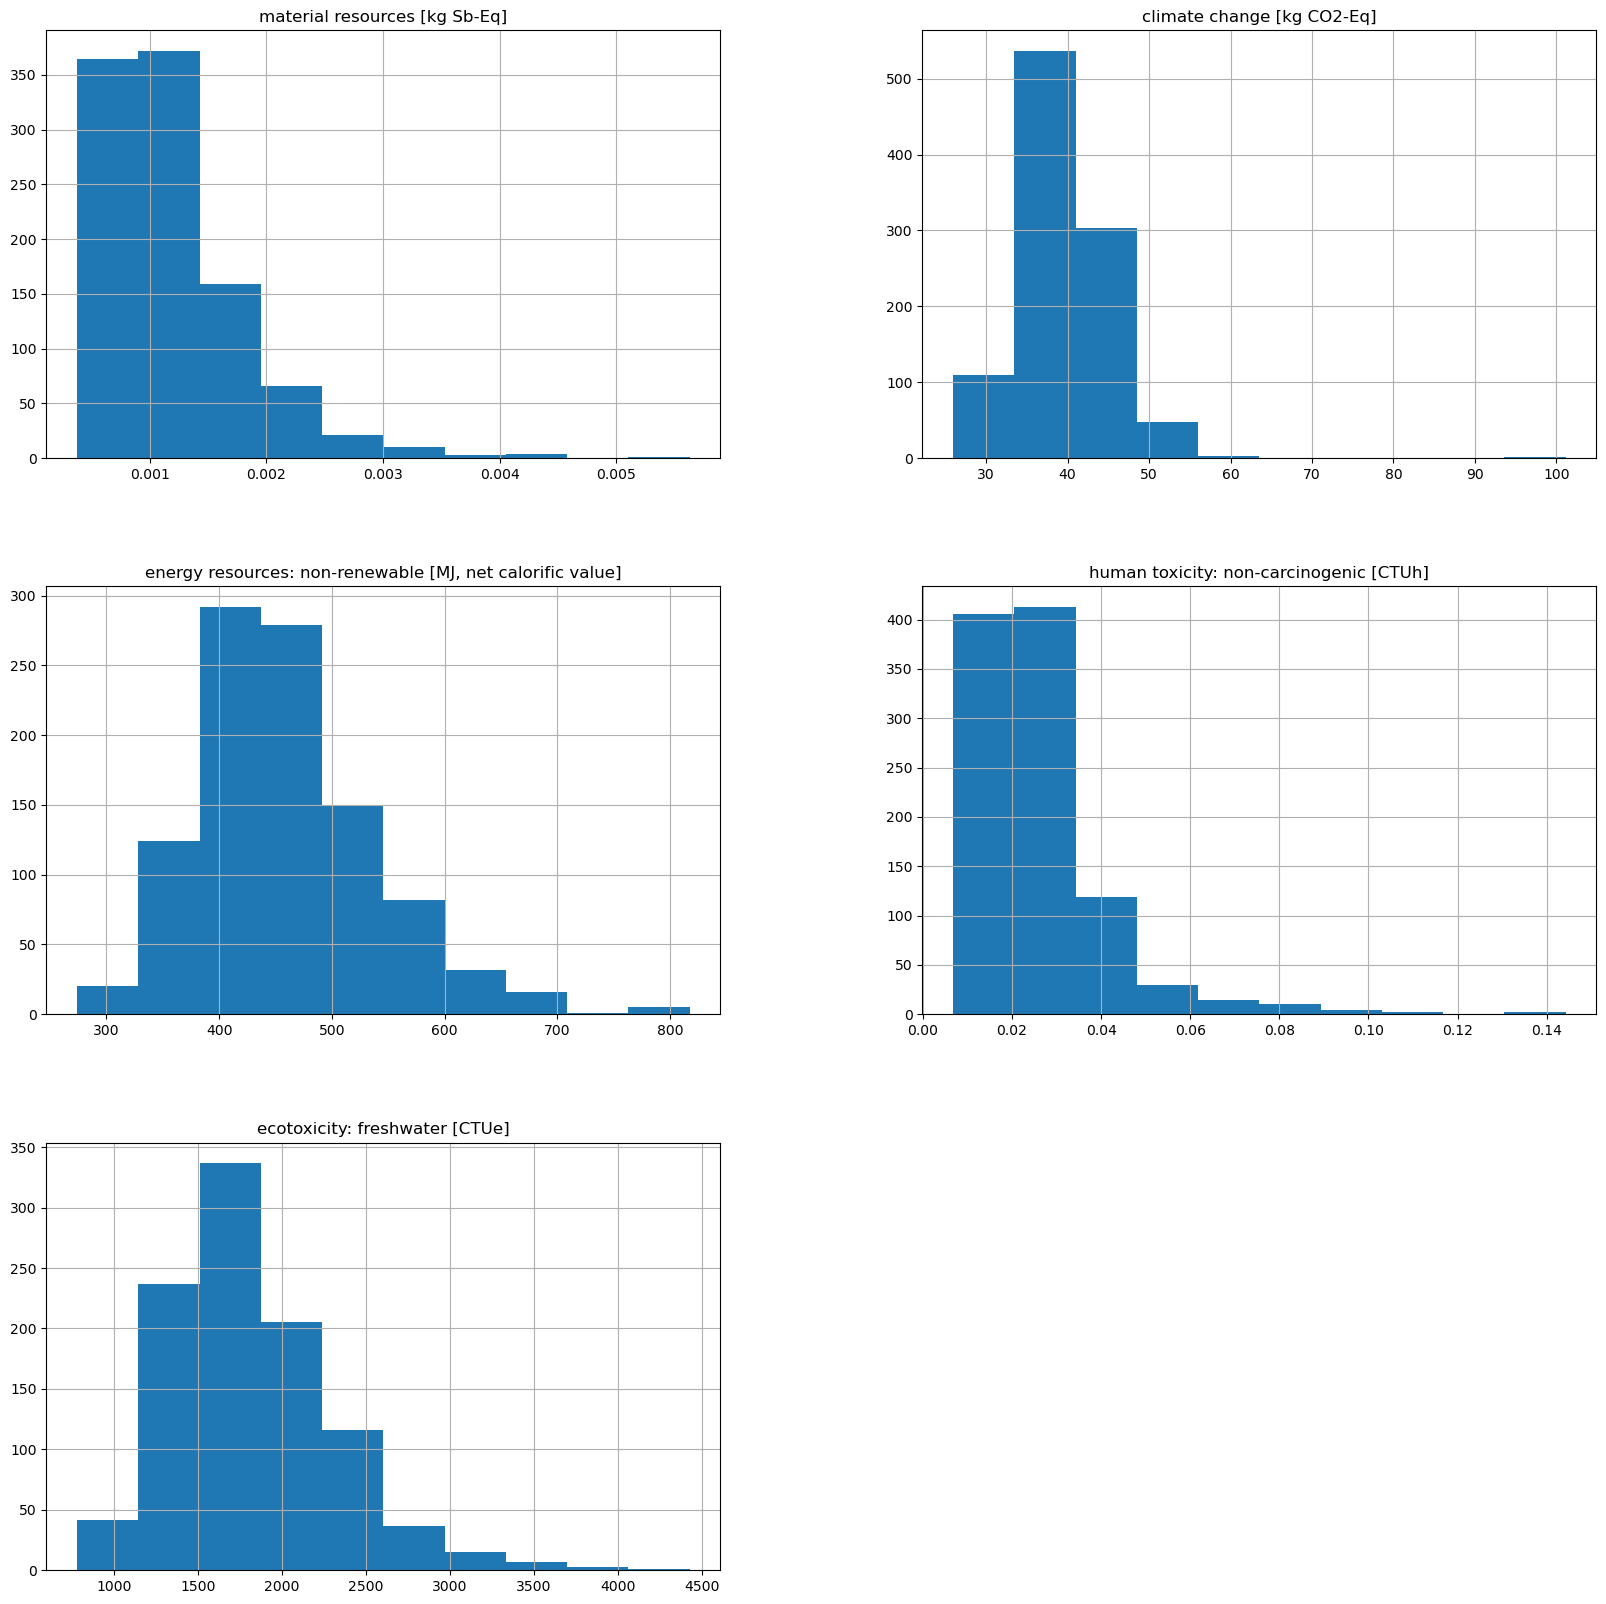

In [110]:
df.T.hist(figsize=(20,20),layout=[3,2])
plt.ylabel('iterations')
plt.xlabel('scores')